In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as  plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

%matplotlib inline
%config InlineBackend.figure_format = "retina"


register_matplotlib_converters()
sns.set(style = "whitegrid", palette = "muted", font_scale = 1.5)

rcParams["figure.figsize"] = 22, 10

In [22]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense , TimeDistributed
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, Flatten, Reshape, MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [11]:
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
data = pd.read_csv("/content/drive/MyDrive/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";")

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan

df = data.drop('NaN', axis=1)
df["z_axis"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
df["z_axis"] = df["z_axis"].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss will show up as NAN
df.dropna(axis=0, how='any', inplace=True)
df.head()
print(df.shape)

<ipython-input-11-56736d26e660>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return np.float(x)


(1098204, 6)


In [12]:
mapping = {'Walking': 0, 'Jogging': 1, 'Upstairs': 2, 'Downstairs': 3, 'Sitting': 4, 'Standing': 5}

# 레이블 인코딩
df['ActivityEncoded'] = df['activity'].map(mapping)
df

,user_id,activity,timestamp,x_axis,y_axis,z_axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1
...,...,...,...,...,...,...,...
1098200,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,4
1098201,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,4
1098202,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,4
1098203,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,4


<Axes: xlabel='activity', ylabel='count'>

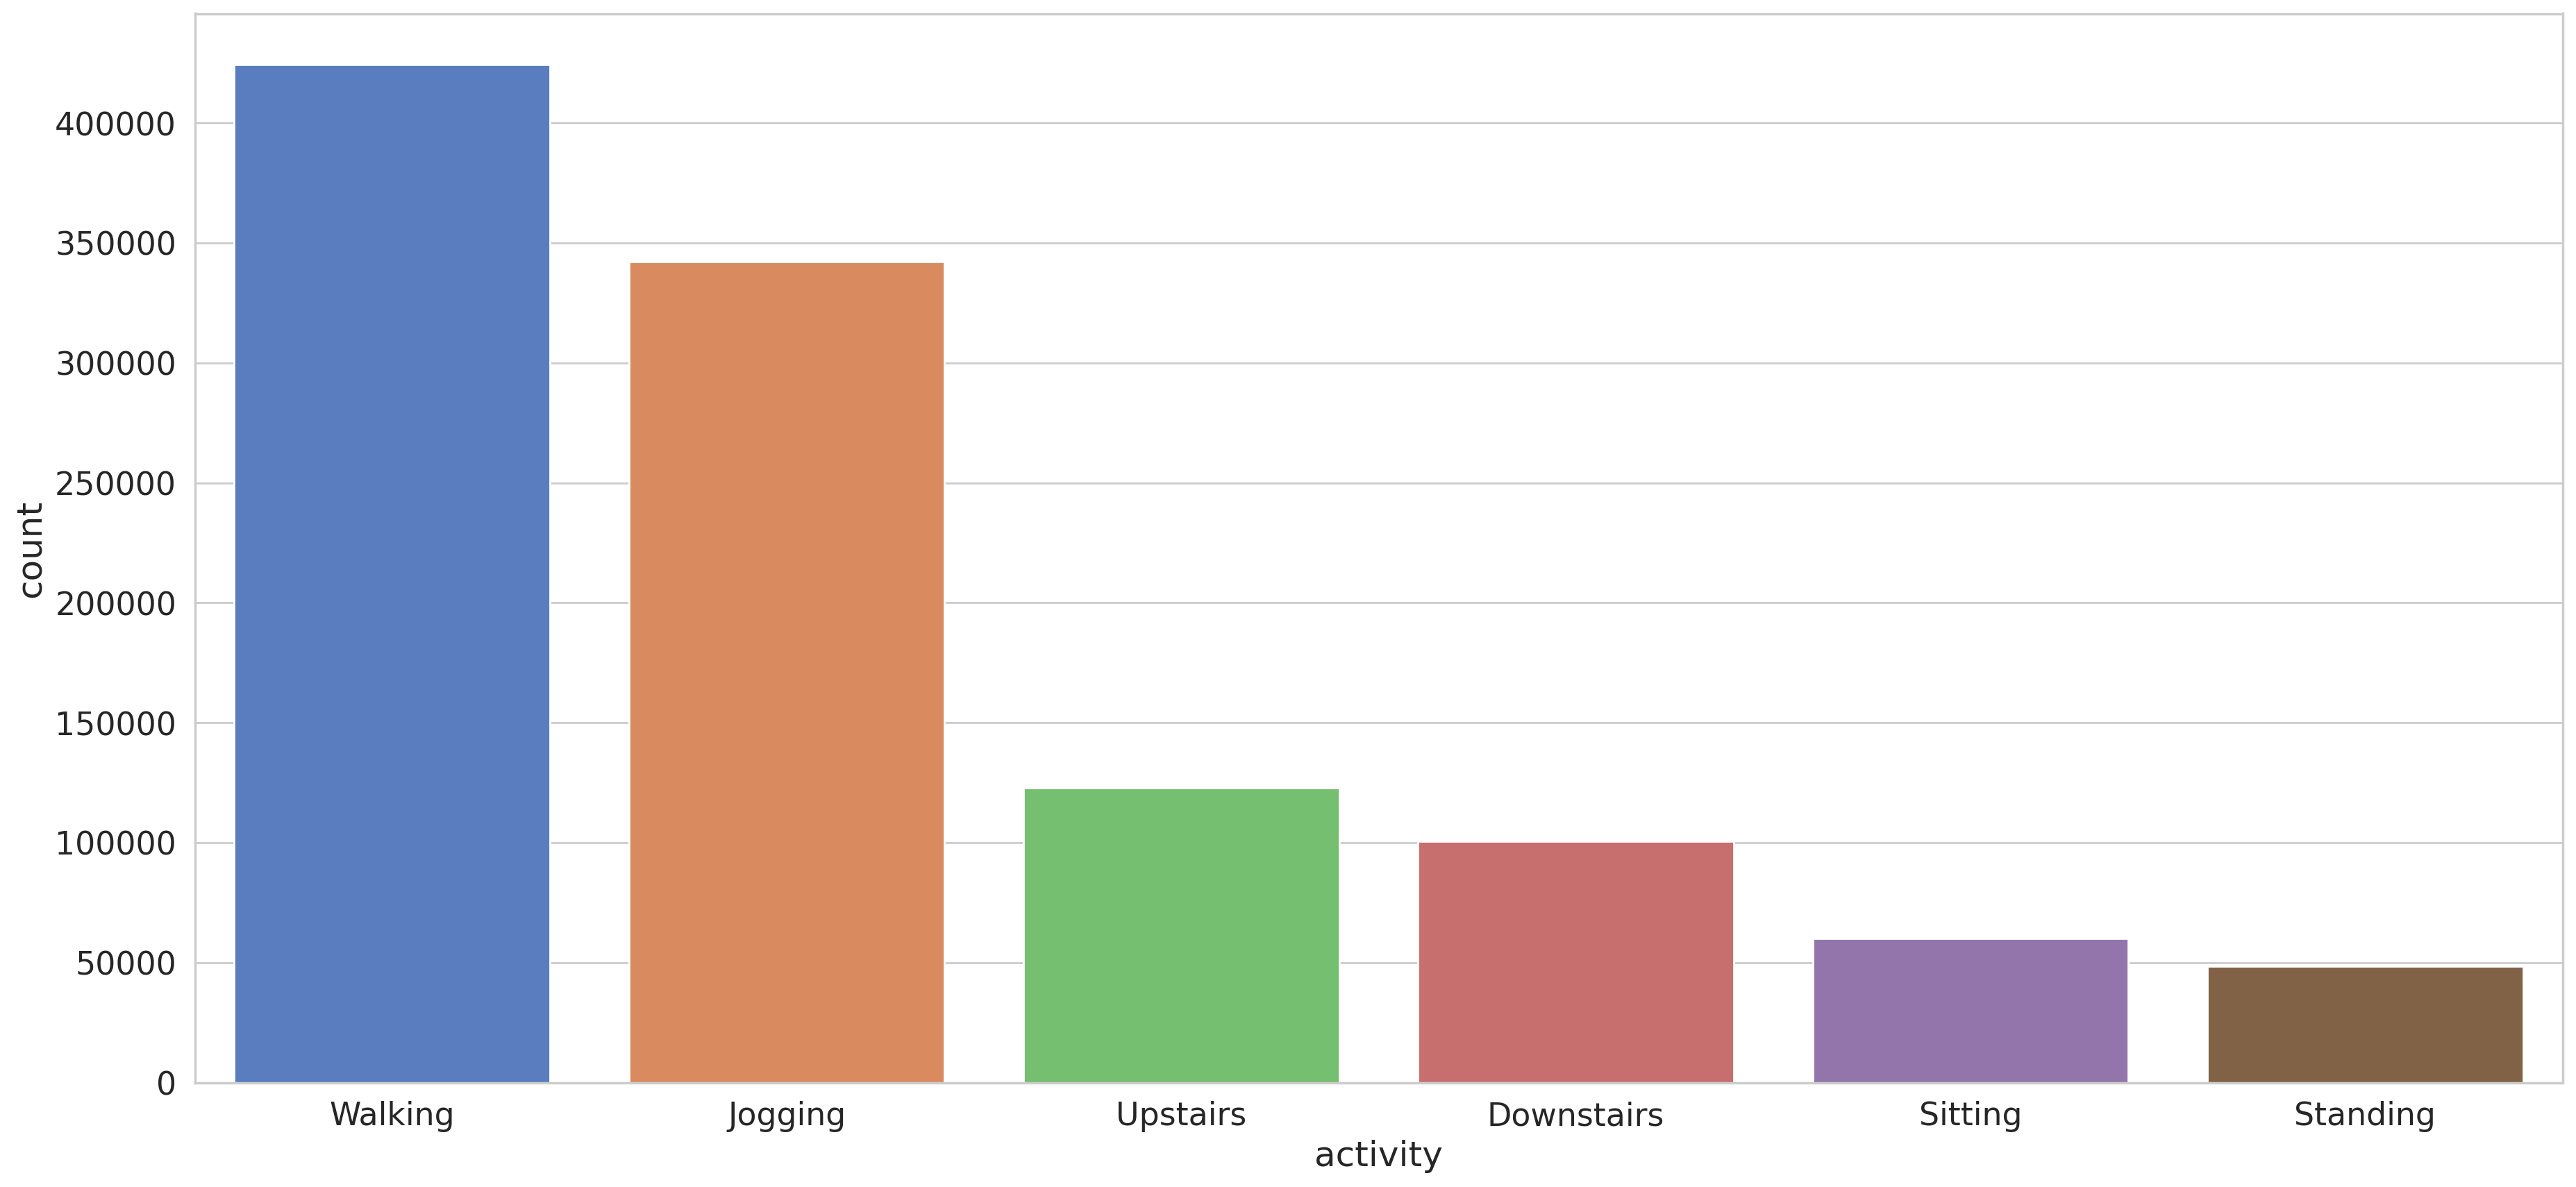

In [ ]:
sns.countplot(x = "activity", data = df, order = df.activity.value_counts().index)

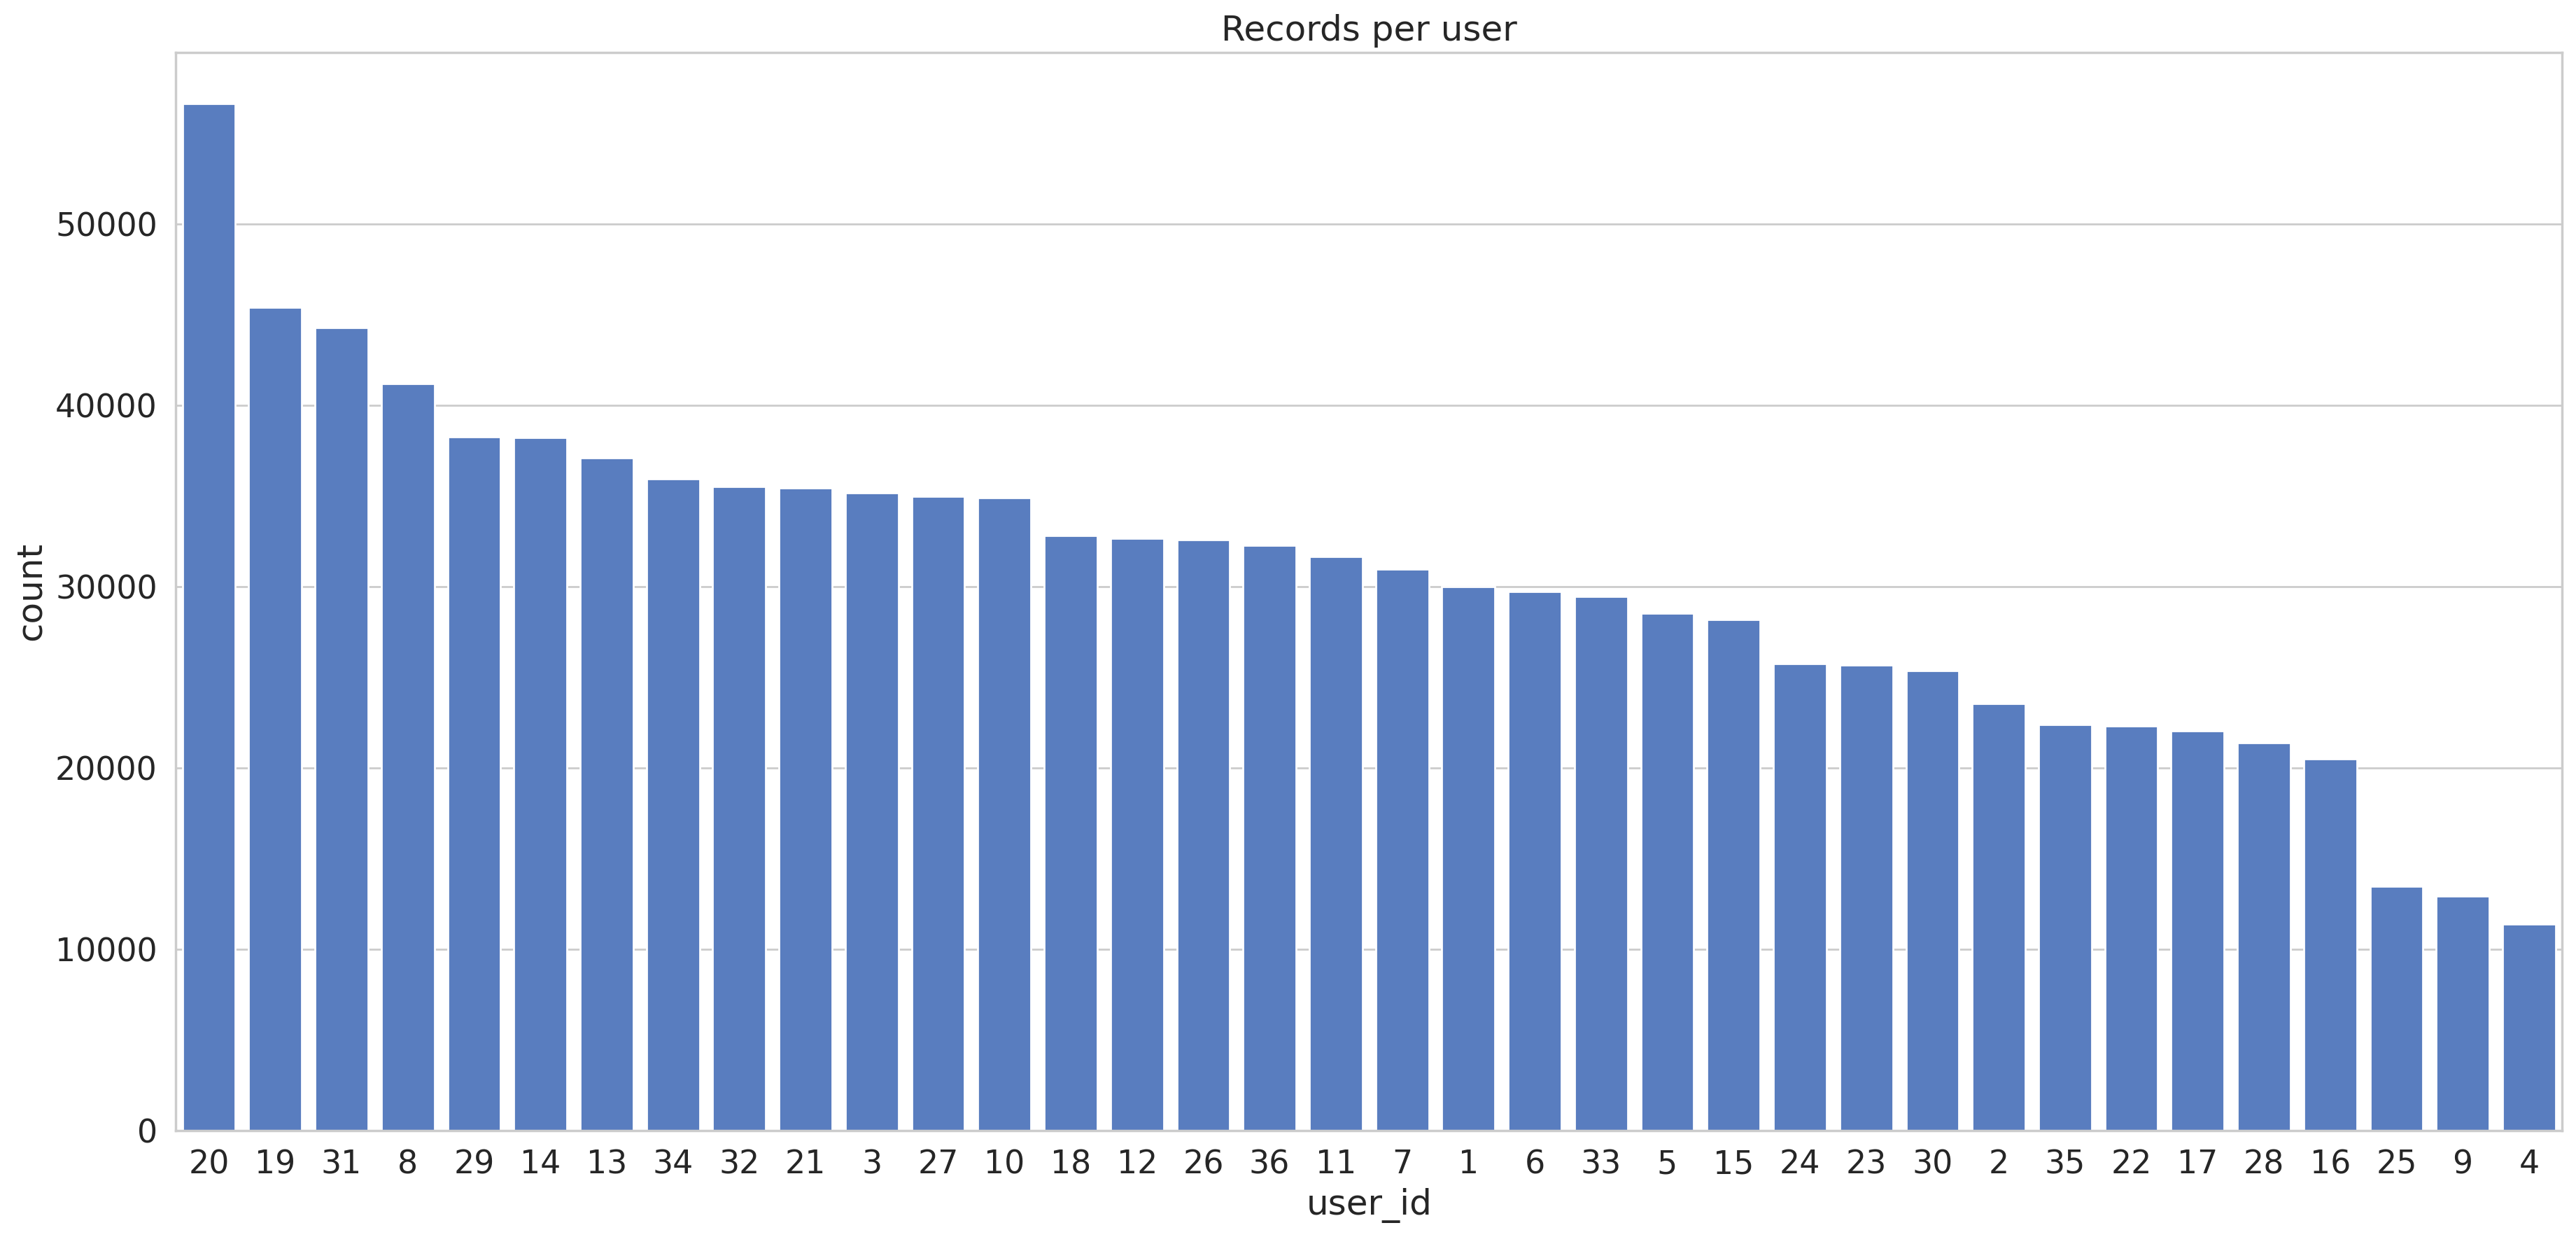

In [ ]:
sns.countplot(x = "user_id", data = df, palette = [sns.color_palette()[0]],
              order = df.user_id.value_counts().index)
plt.title("Records per user");


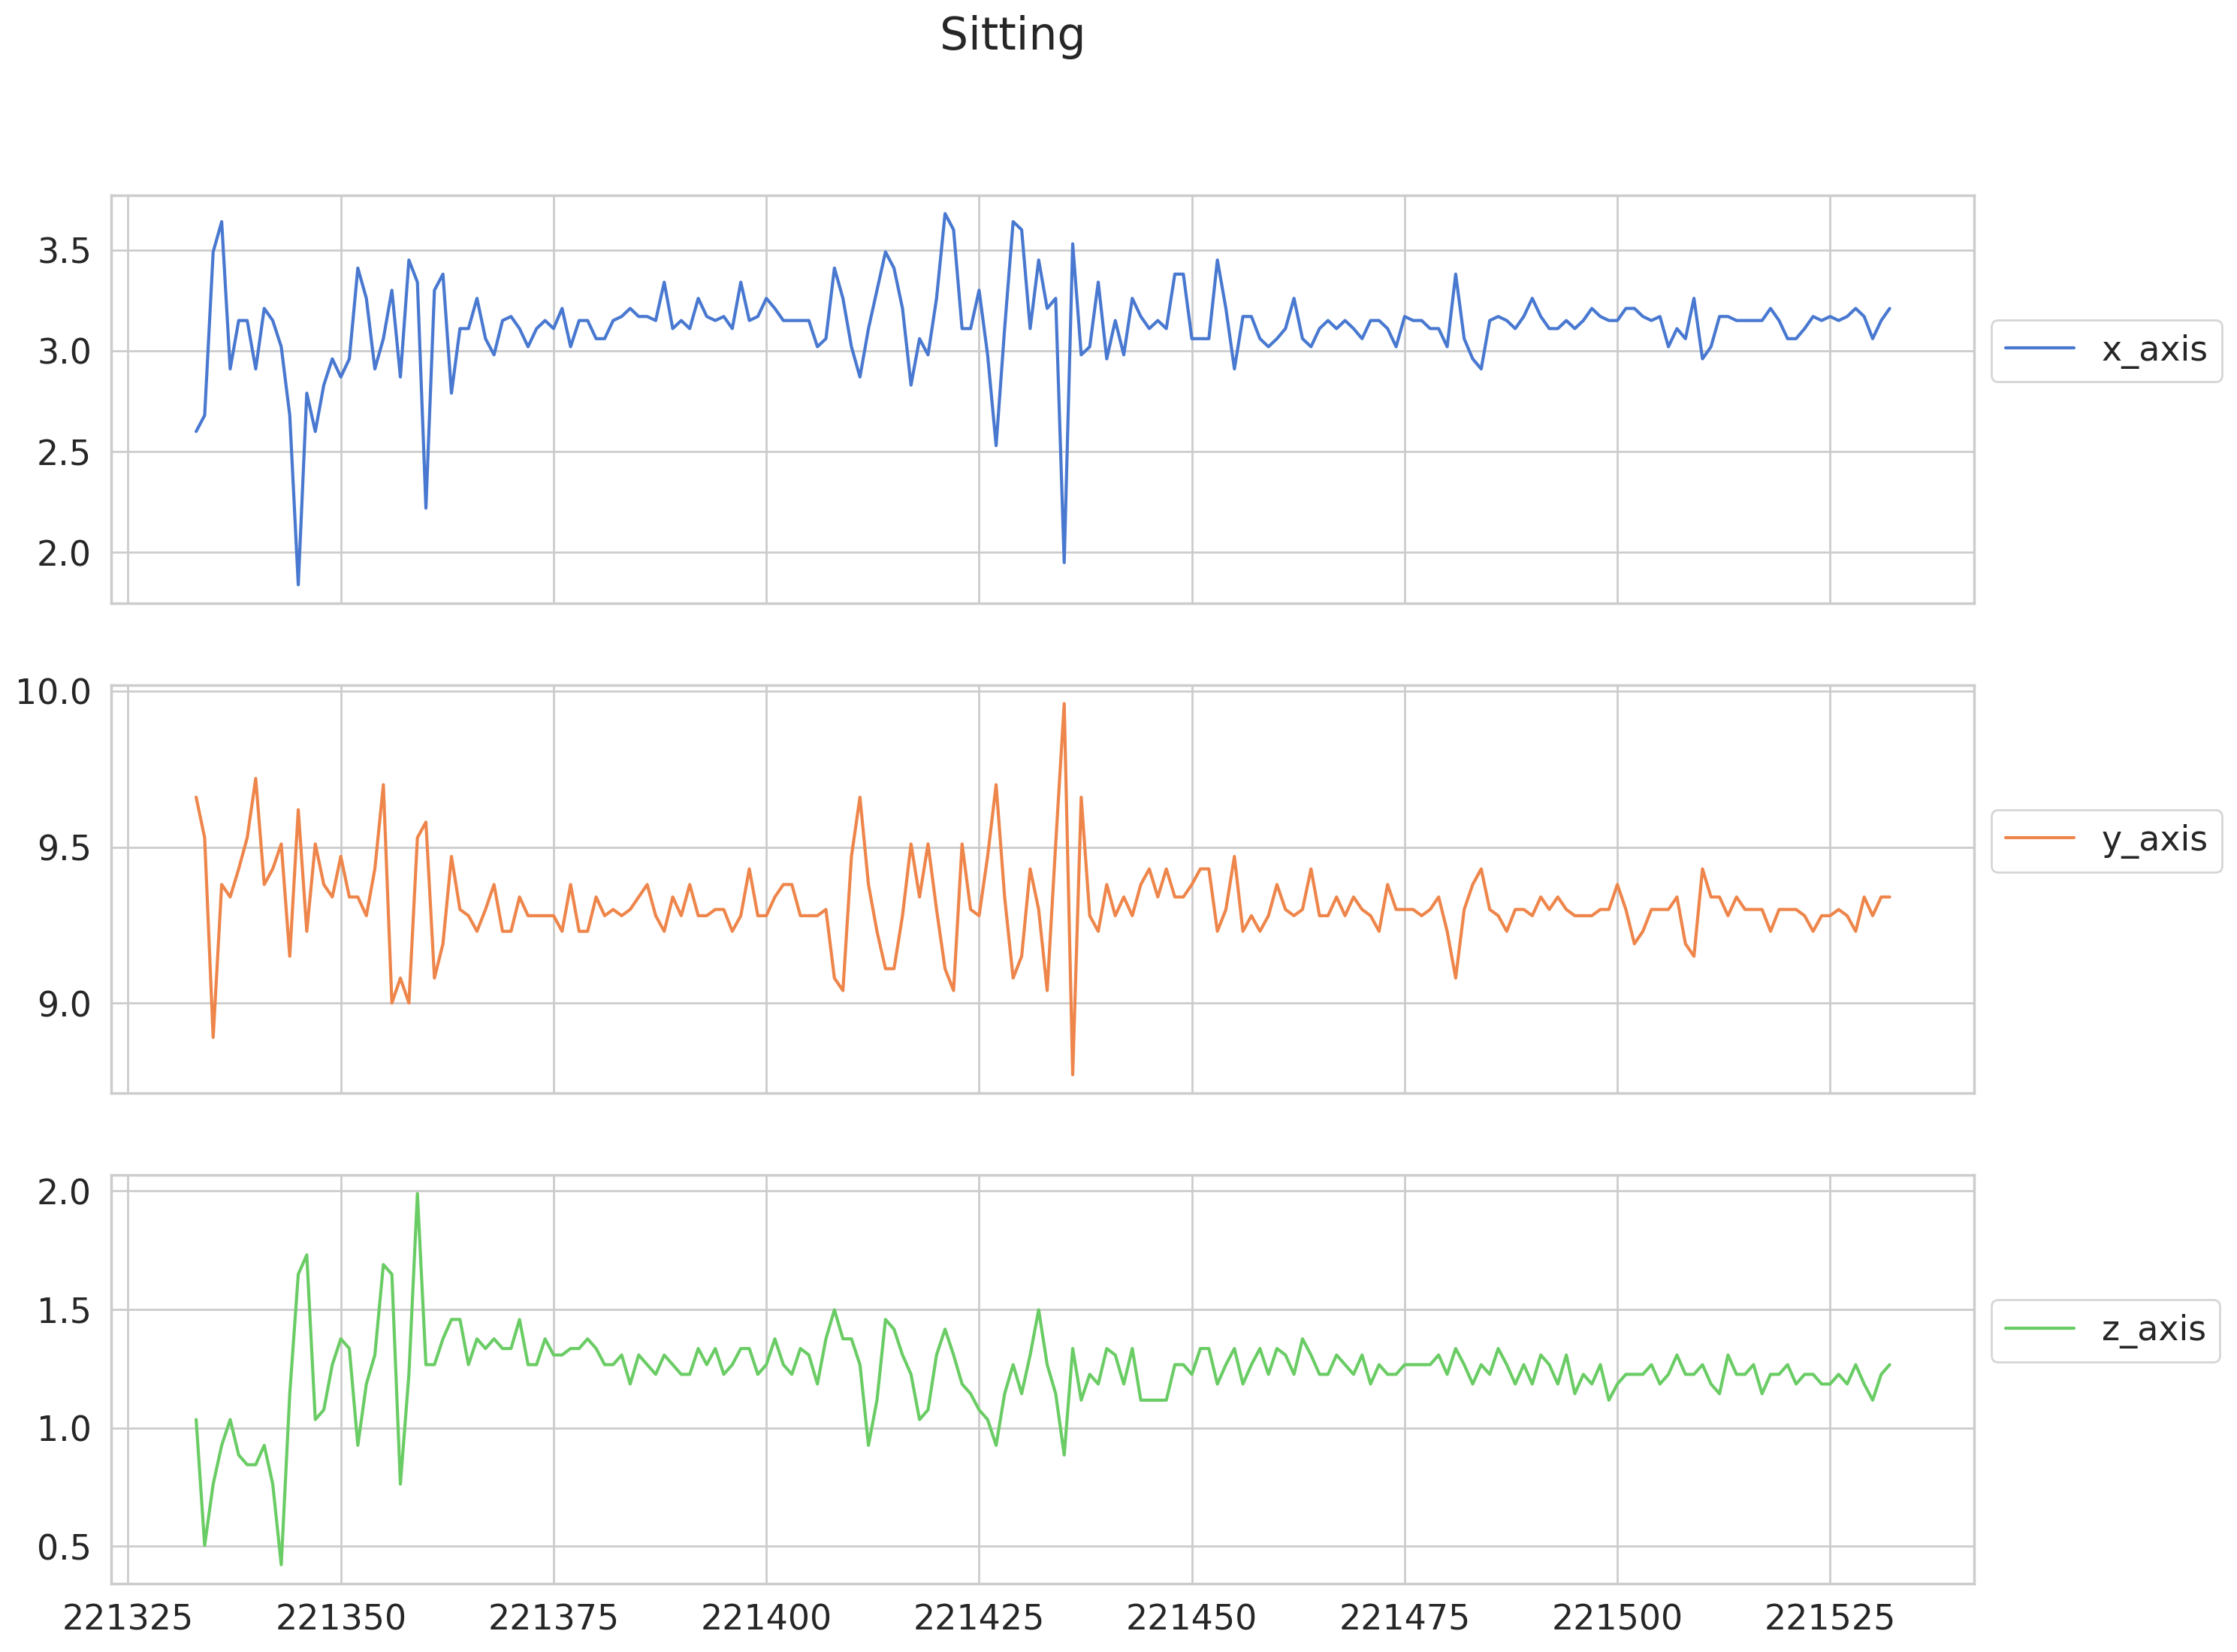

In [ ]:

def plot_activity(activity, df):
    data = df[df["activity"] == activity][["x_axis", "y_axis", "z_axis"]][:200]
    axis = data.plot(subplots = True, figsize = (16, 12), title = activity)
    for ax in axis:
        ax.legend(loc = "lower left", bbox_to_anchor = (1.0, 0.5))

plot_activity("Sitting", df)


In [13]:
indexes = df[ (df['activity'] == 'Sitting') | (df['activity'] == 'Standing')].index
df.drop(indexes , inplace=True)

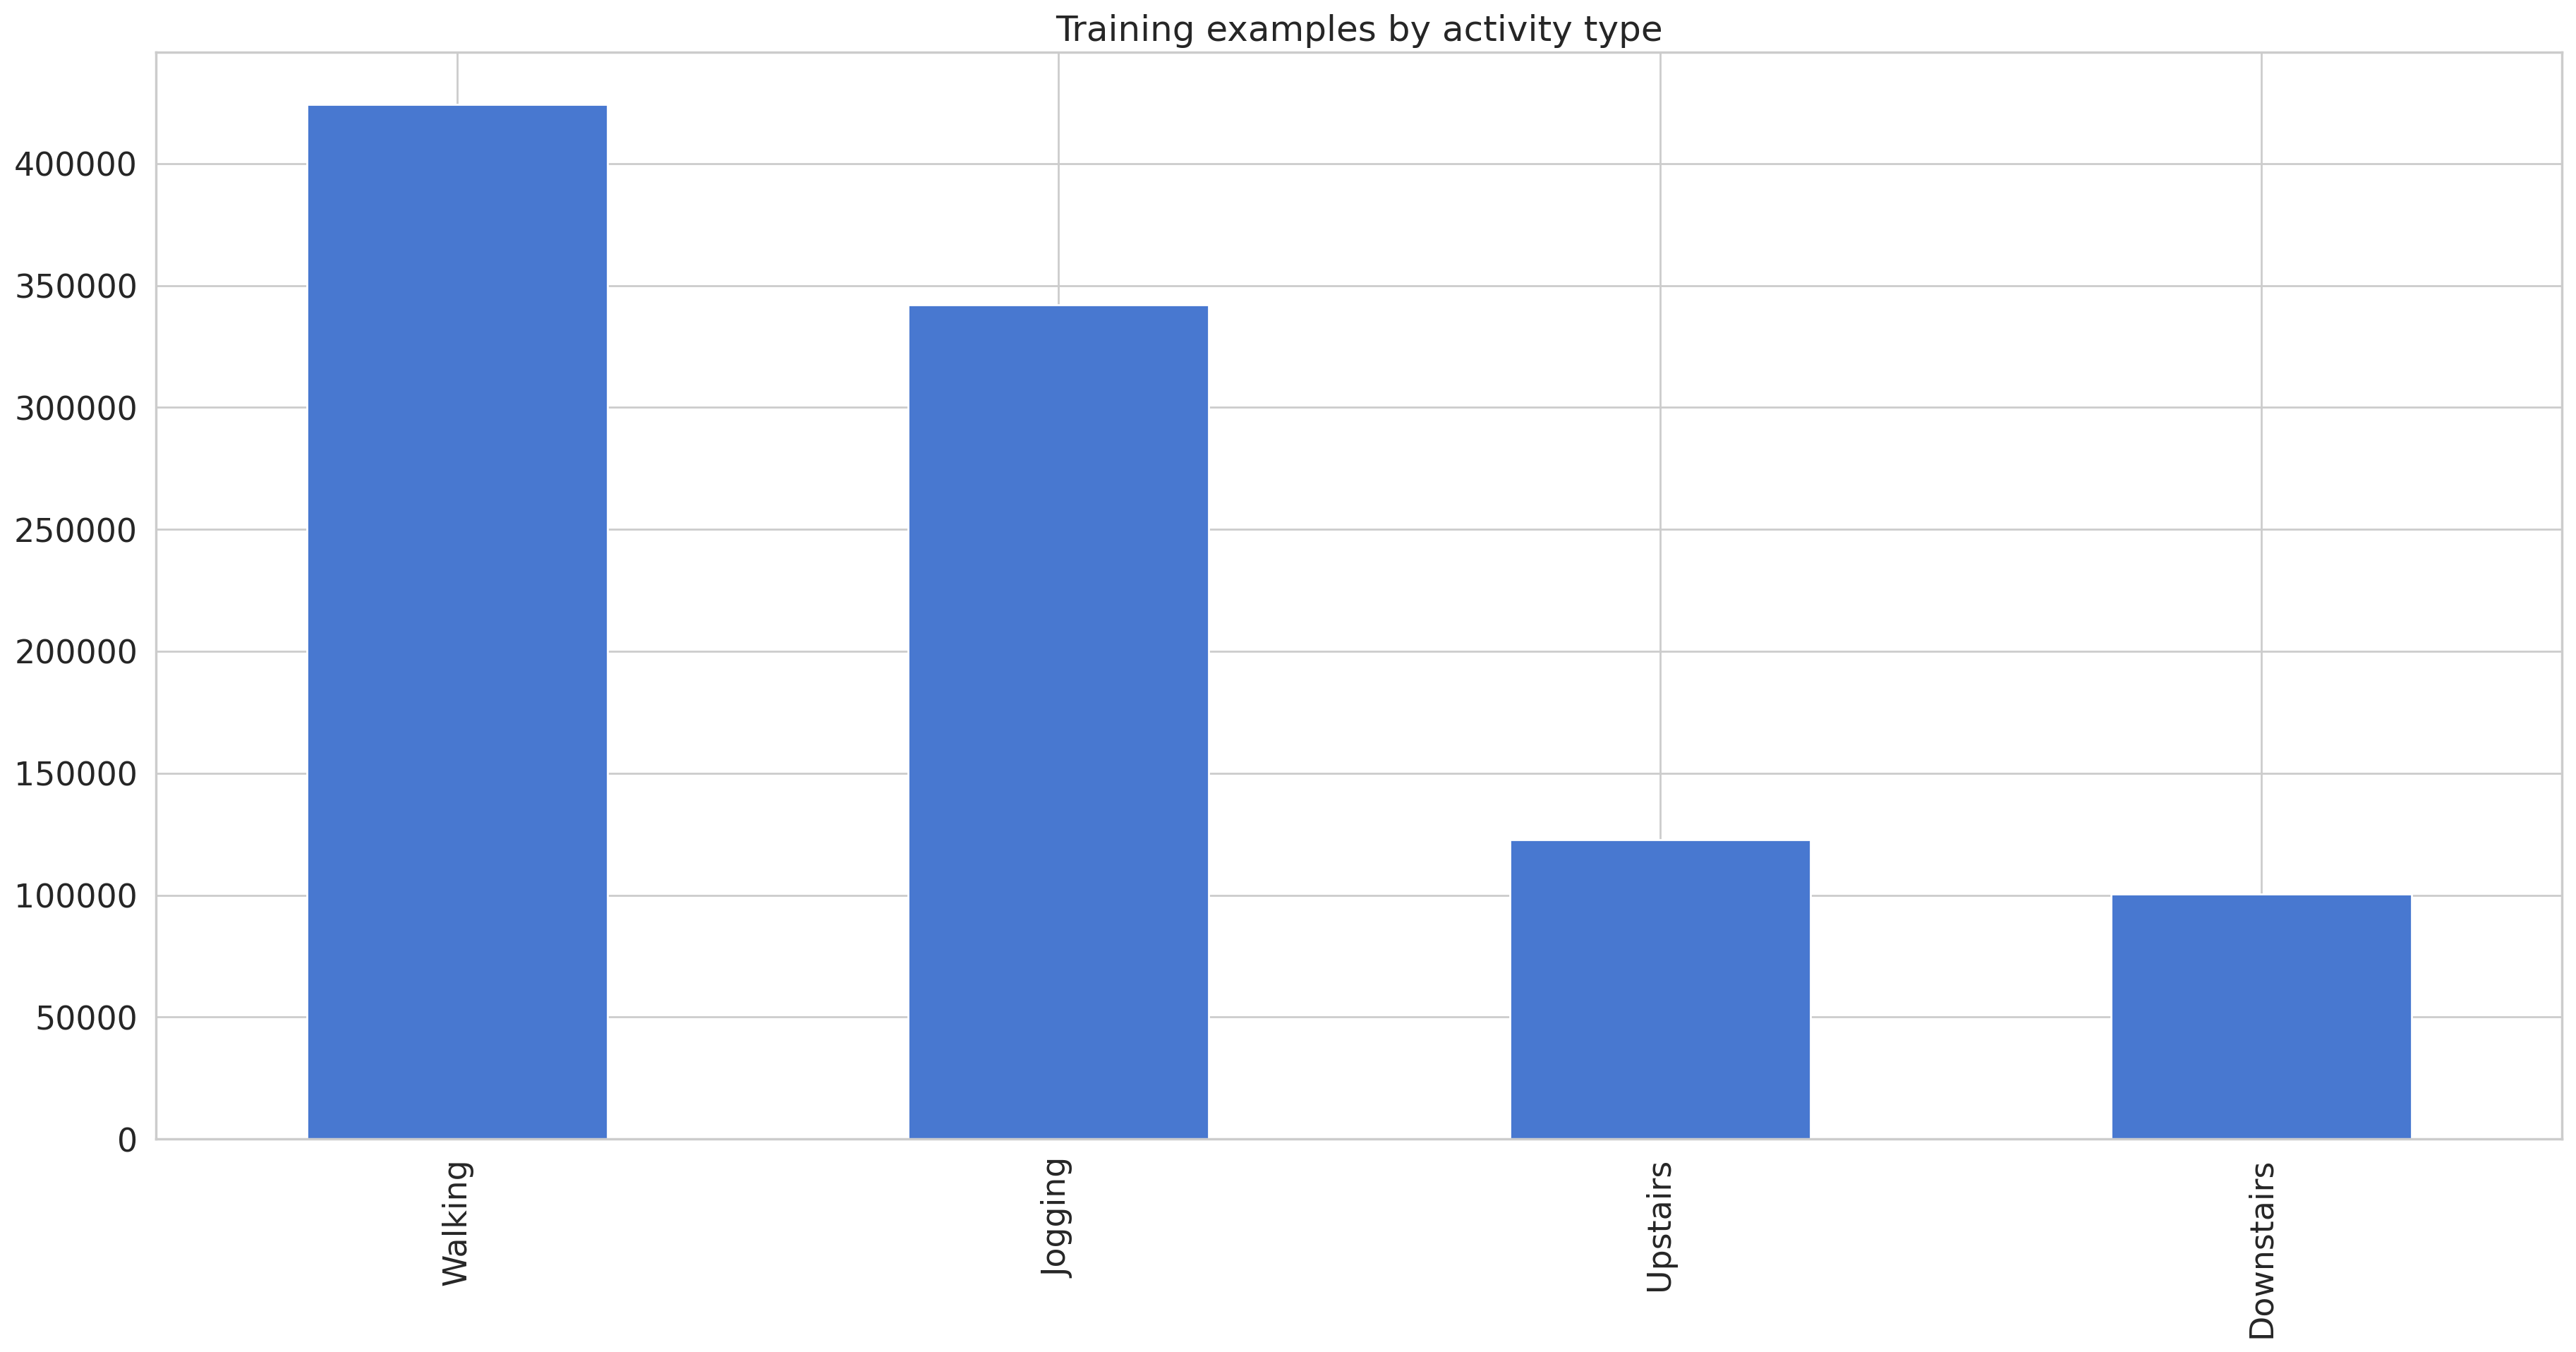

In [ ]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

In [14]:
from sklearn.preprocessing import RobustScaler

scale_columns = ["x_axis", "y_axis", "z_axis"]

scaler = RobustScaler()

scaler = scaler.fit(df[scale_columns])

df.loc[:, scale_columns] = scaler.transform(df[scale_columns].to_numpy())
df

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


,user_id,activity,timestamp,x_axis,y_axis,z_axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.139064,0.528798,0.162904,1
1,33,Jogging,49106062271000,0.627996,0.365980,0.257510,1
2,33,Jogging,49106112167000,0.613350,0.322145,0.039629,1
3,33,Jogging,49106222305000,-0.128080,1.197291,0.693271,1
4,33,Jogging,49106332290000,-0.204969,0.463045,1.573395,1
...,...,...,...,...,...,...,...
1093534,19,Downstairs,131357151521000,-0.602151,-0.017241,0.635659,3
1093535,19,Downstairs,131357191438000,-0.987903,0.155172,0.248370,3
1093536,19,Downstairs,131357231630000,-1.235215,0.718391,0.119975,3
1093537,19,Downstairs,131357271516000,-1.065860,0.026437,-0.524103,3


In [16]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_data, y_data = create_dataset(df[["x_axis", "y_axis", "z_axis"]], df.ActivityEncoded, TIME_STEPS,
                                  STEP)
X_train, X_test,y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, stratify=  y_data )
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size = 0.2, stratify=  y_train )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
n_steps = 4
n_features = X_train.shape[2]
n_length = 50

X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))
X_val = X_val.reshape((X_val.shape[0], n_steps, n_length, n_features))

(15834, 200, 3) (15834, 1)
(4949, 200, 3) (4949, 1)


In [17]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse = False)
enc = enc.fit(y_train)

y_train_hot = enc.transform(y_train)
y_test_hot = enc.transform(y_test)
y_val_hot = enc.transform(y_val)

print(X_train.shape, y_train_hot.shape, X_test.shape, y_test_hot.shape)

(15834, 4, 50, 3) (15834, 4) (4949, 4, 50, 3) (4949, 4)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [20]:
#Epoch 500

BATCH_SIZE = 32

verbose,epochs,batch_size=1,10, BATCH_SIZE

n_timesteps, n_features, n_outputs = n_steps * n_length, X_train.shape[3], y_train_hot.shape[1]
n_timesteps,n_features,n_outputs

(200, 3, 4)

# CNN1 - LSTM1

In [23]:
# Model 1
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))

model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, None, 48, 64)      640       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, None, 48, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, None, 24, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, None, 1536)        0         
 stributed)                                                      
                                                                 
 lstm (LSTM)                 (None, 100)              

In [24]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
124/124 [==============================] - 15s 92ms/step - loss: 0.6500 - accuracy: 0.7557 - val_loss: 0.4207 - val_accuracy: 0.8343
Epoch 2/10
124/124 [==============================] - 11s 86ms/step - loss: 0.3720 - accuracy: 0.8546 - val_loss: 0.3747 - val_accuracy: 0.8333
Epoch 3/10
124/124 [==============================] - 12s 93ms/step - loss: 0.2943 - accuracy: 0.8784 - val_loss: 0.2541 - val_accuracy: 0.8906
Epoch 4/10
124/124 [==============================] - 12s 94ms/step - loss: 0.2368 - accuracy: 0.9058 - val_loss: 0.2207 - val_accuracy: 0.9156
Epoch 5/10
124/124 [==============================] - 12s 93ms/step - loss: 0.1970 - accuracy: 0.9248 - val_loss: 0.2112 - val_accuracy: 0.9232
Epoch 6/10
124/124 [==============================] - 12s 101ms/step - loss: 0.1556 - accuracy: 0.9411 - val_loss: 0.1565 - val_accuracy: 0.9424
Epoch 7/10
124/124 [==============================] - 12s 96ms/step - loss: 0.1308 - accuracy: 0.9512 - val_loss: 0.1726 - val_accuracy

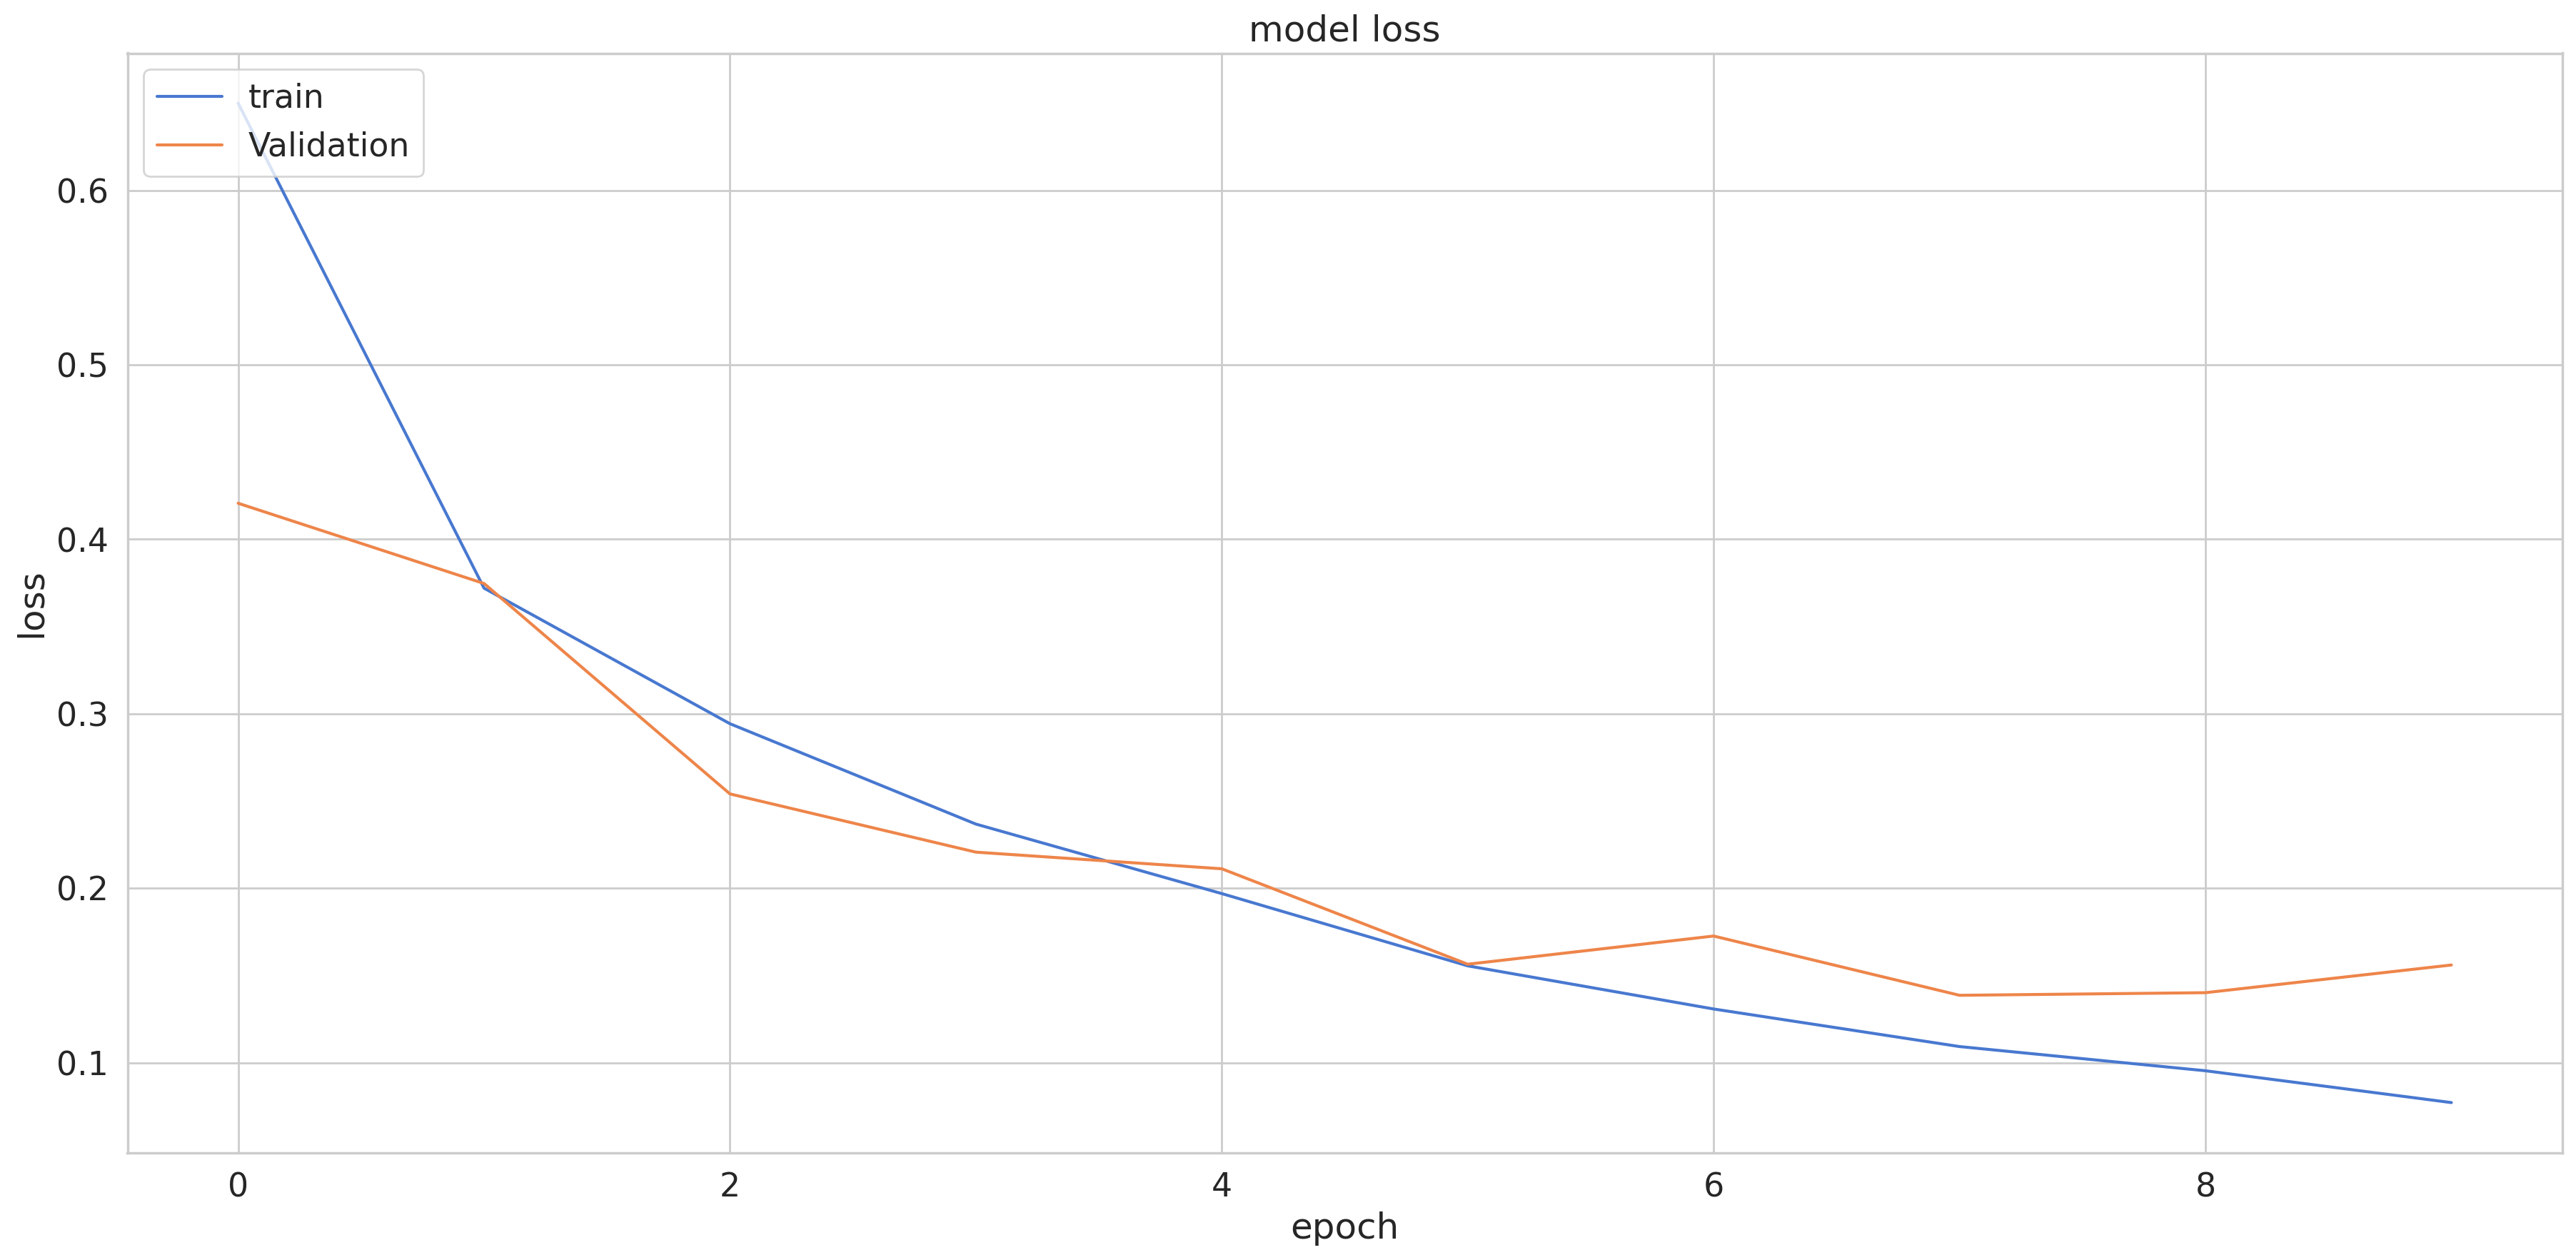

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

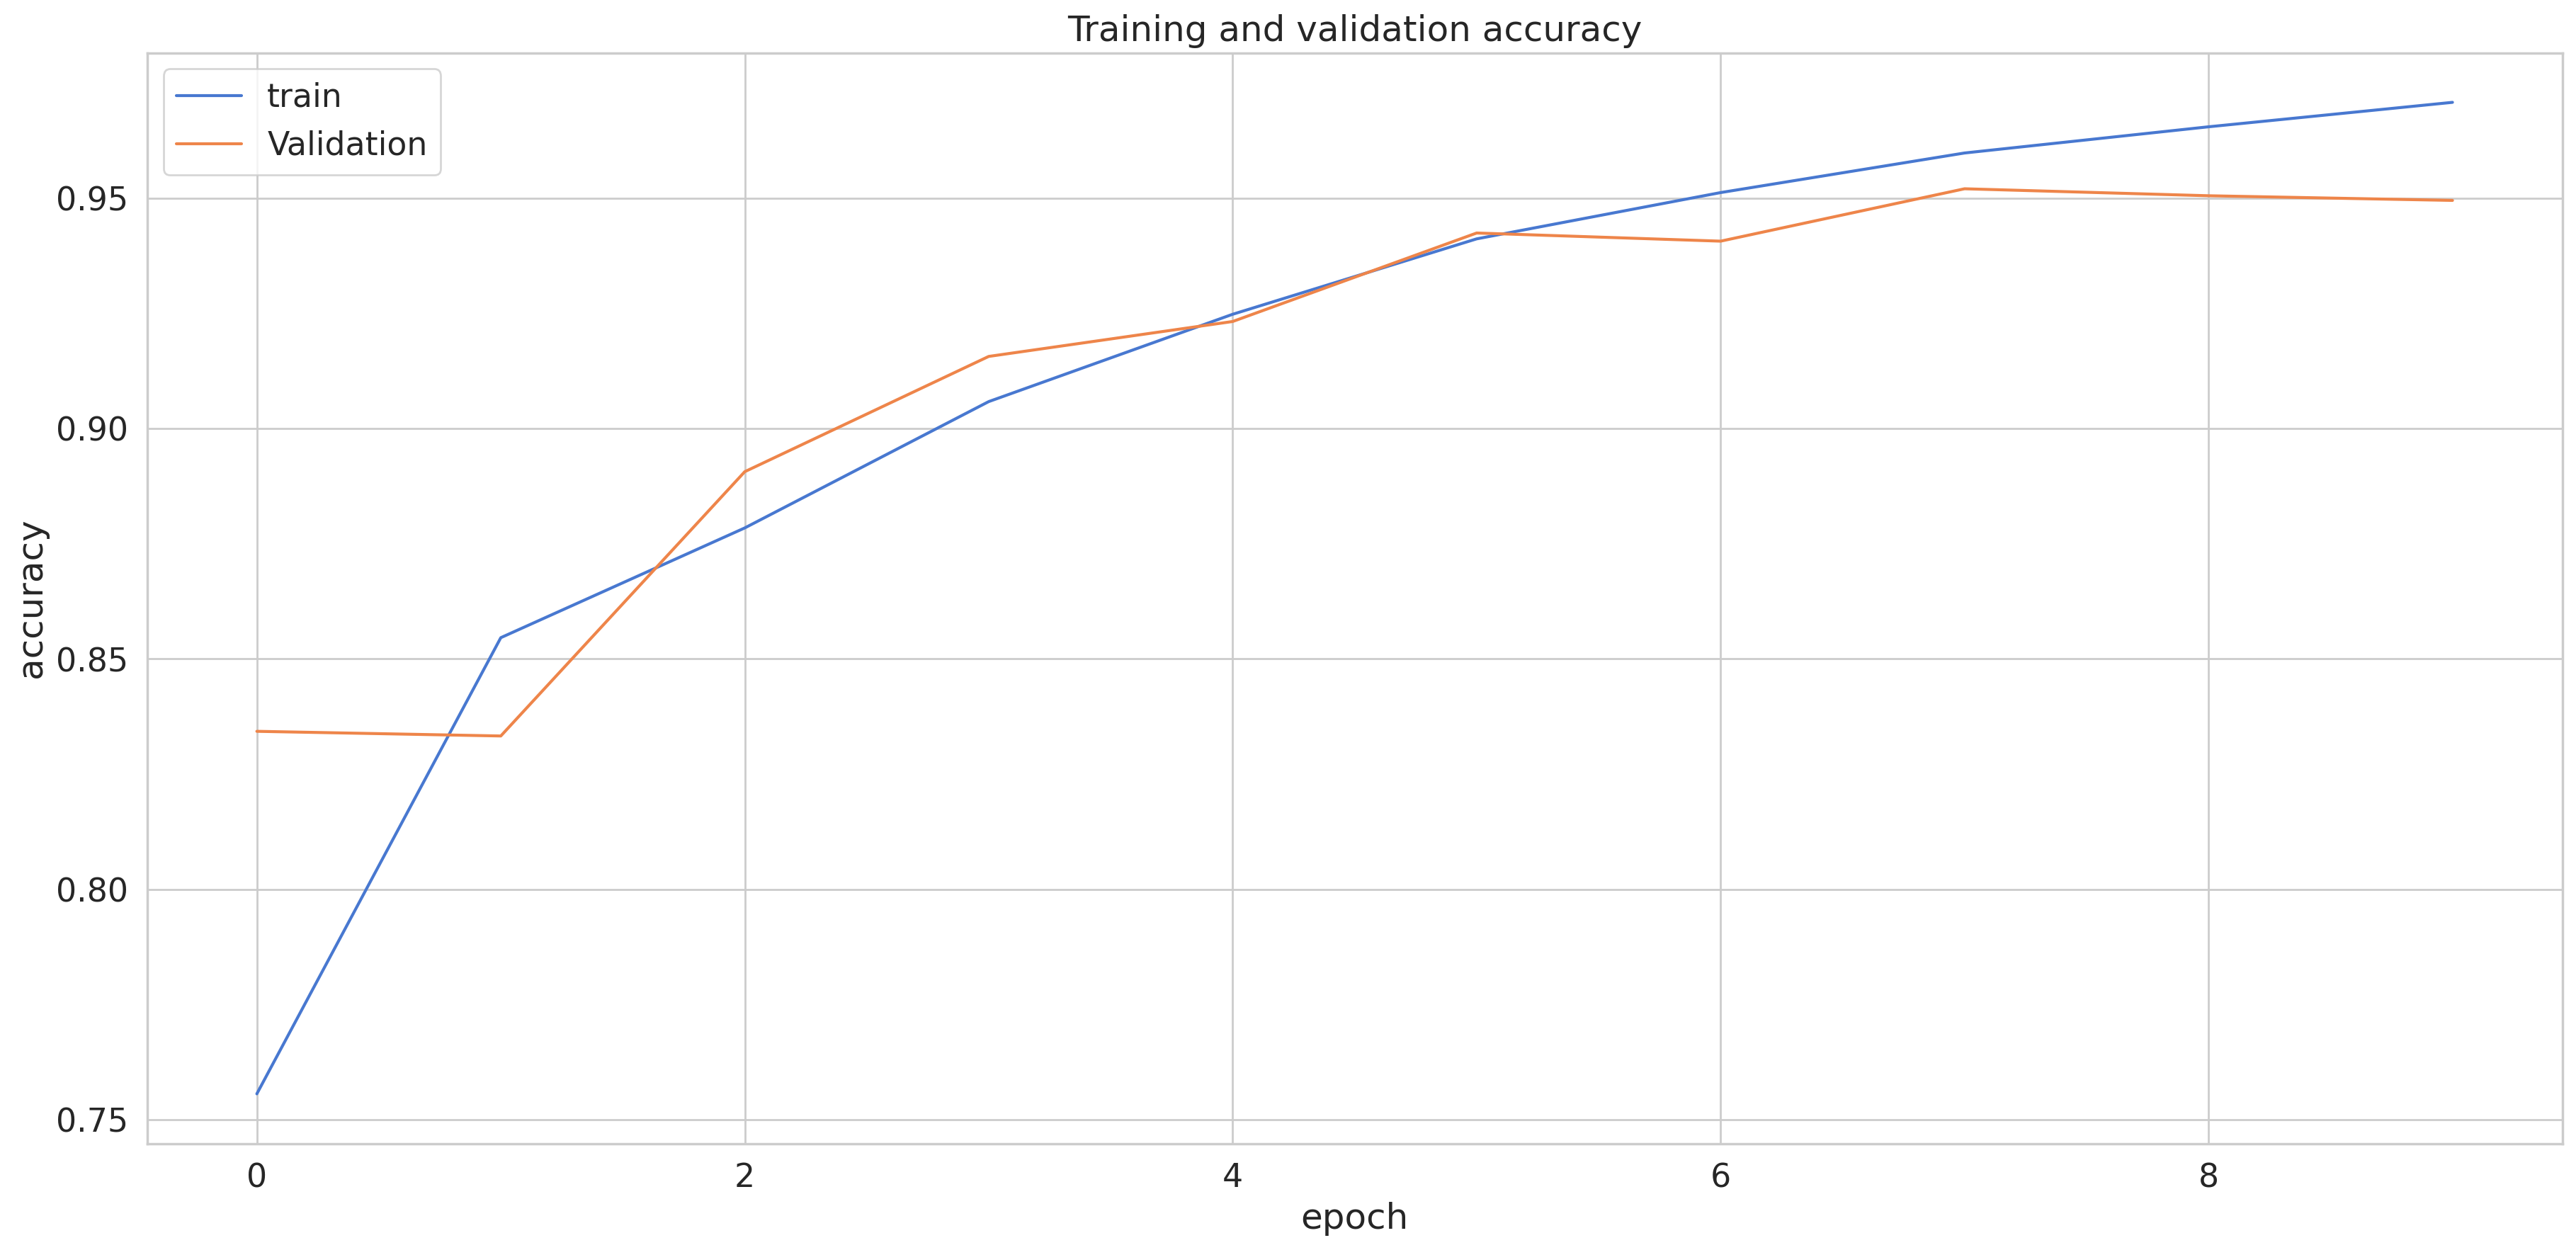

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

155/155 [==============================] - 2s 8ms/step
f1_score =  0.9591519396445803
0.959789856536674
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2123
           1       0.97      1.00      0.98      1710
           2       0.91      0.80      0.85       615
           3       0.86      0.91      0.89       501

    accuracy                           0.96      4949
   macro avg       0.93      0.92      0.93      4949
weighted avg       0.96      0.96      0.96      4949



<Axes: >

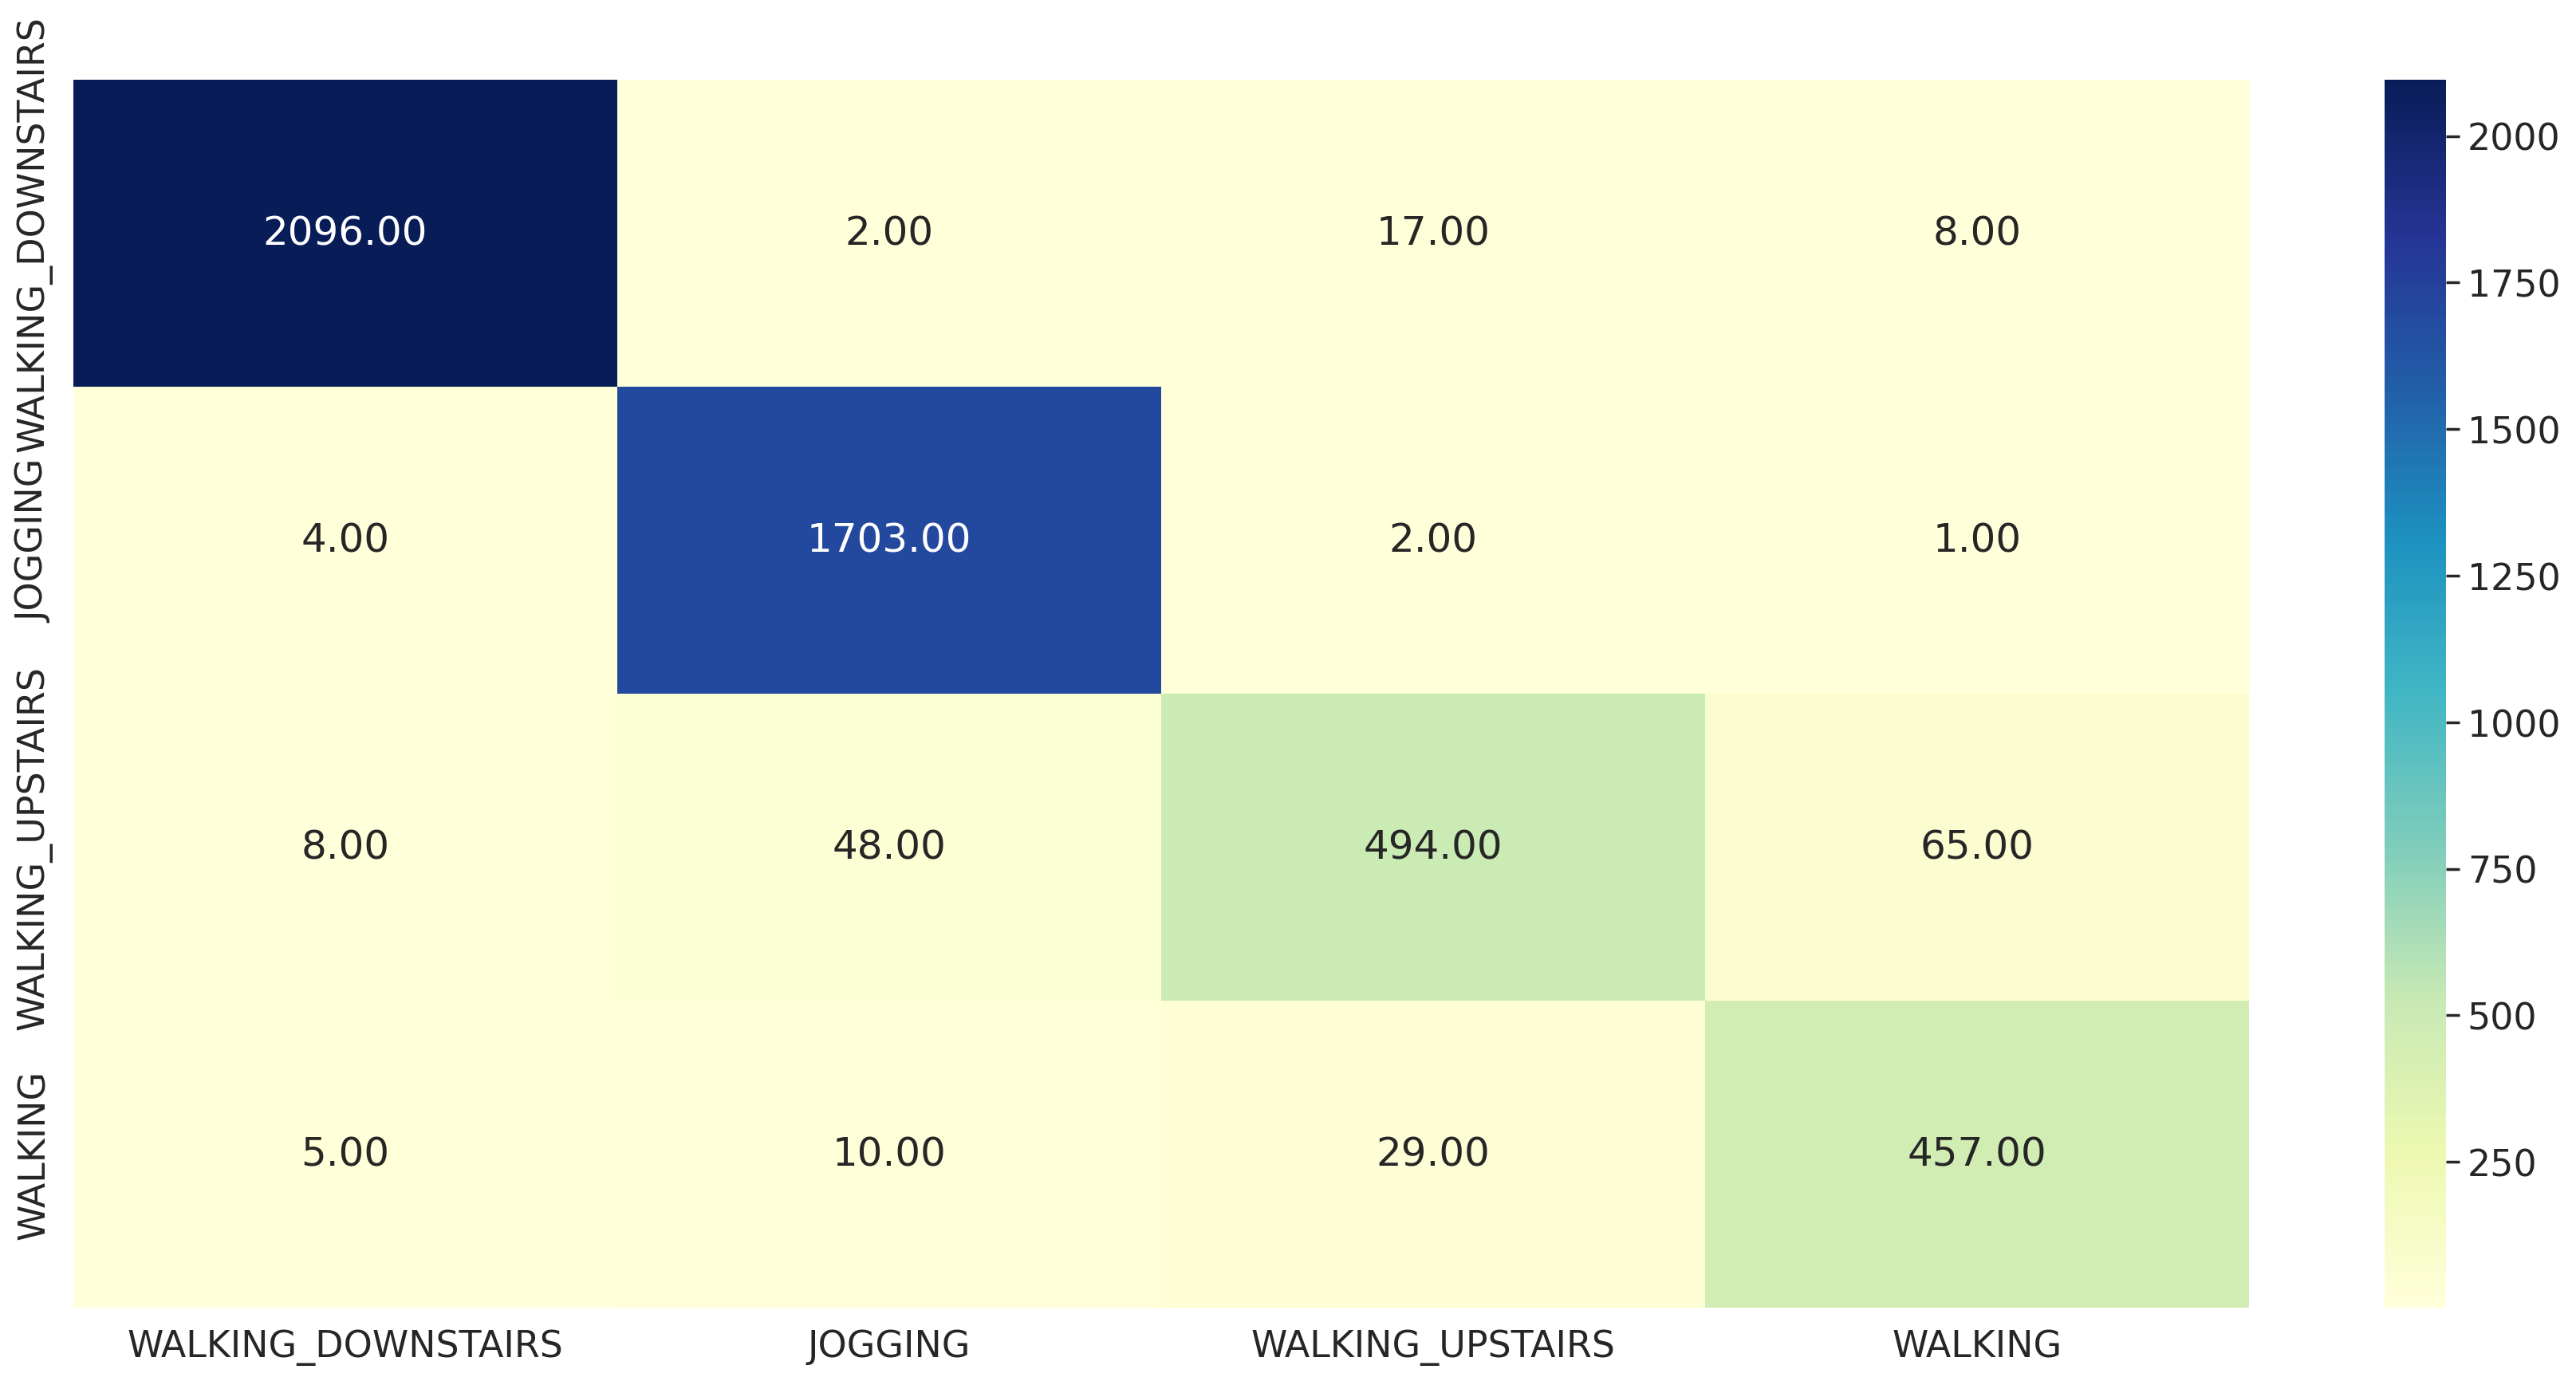

In [27]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['WALKING_DOWNSTAIRS','JOGGING','WALKING_UPSTAIRS','WALKING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN1 - LSTM2

In [28]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDi  (None, None, 48, 64)      640       
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, None, 48, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_6 (TimeDi  (None, None, 24, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_7 (TimeDi  (None, None, 1536)        0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, None, 100)        

In [29]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
124/124 [==============================] - 19s 112ms/step - loss: 0.6883 - accuracy: 0.7455 - val_loss: 0.4503 - val_accuracy: 0.8368
Epoch 2/10
124/124 [==============================] - 13s 102ms/step - loss: 0.3752 - accuracy: 0.8465 - val_loss: 0.3087 - val_accuracy: 0.8628
Epoch 3/10
124/124 [==============================] - 13s 106ms/step - loss: 0.2965 - accuracy: 0.8762 - val_loss: 0.2822 - val_accuracy: 0.8942
Epoch 4/10
124/124 [==============================] - 13s 104ms/step - loss: 0.2211 - accuracy: 0.9163 - val_loss: 0.1937 - val_accuracy: 0.9298
Epoch 5/10
124/124 [==============================] - 16s 126ms/step - loss: 0.1759 - accuracy: 0.9350 - val_loss: 0.1746 - val_accuracy: 0.9414
Epoch 6/10
124/124 [==============================] - 13s 105ms/step - loss: 0.1460 - accuracy: 0.9471 - val_loss: 0.1514 - val_accuracy: 0.9500
Epoch 7/10
124/124 [==============================] - 15s 120ms/step - loss: 0.1171 - accuracy: 0.9591 - val_loss: 0.1384 - val_ac

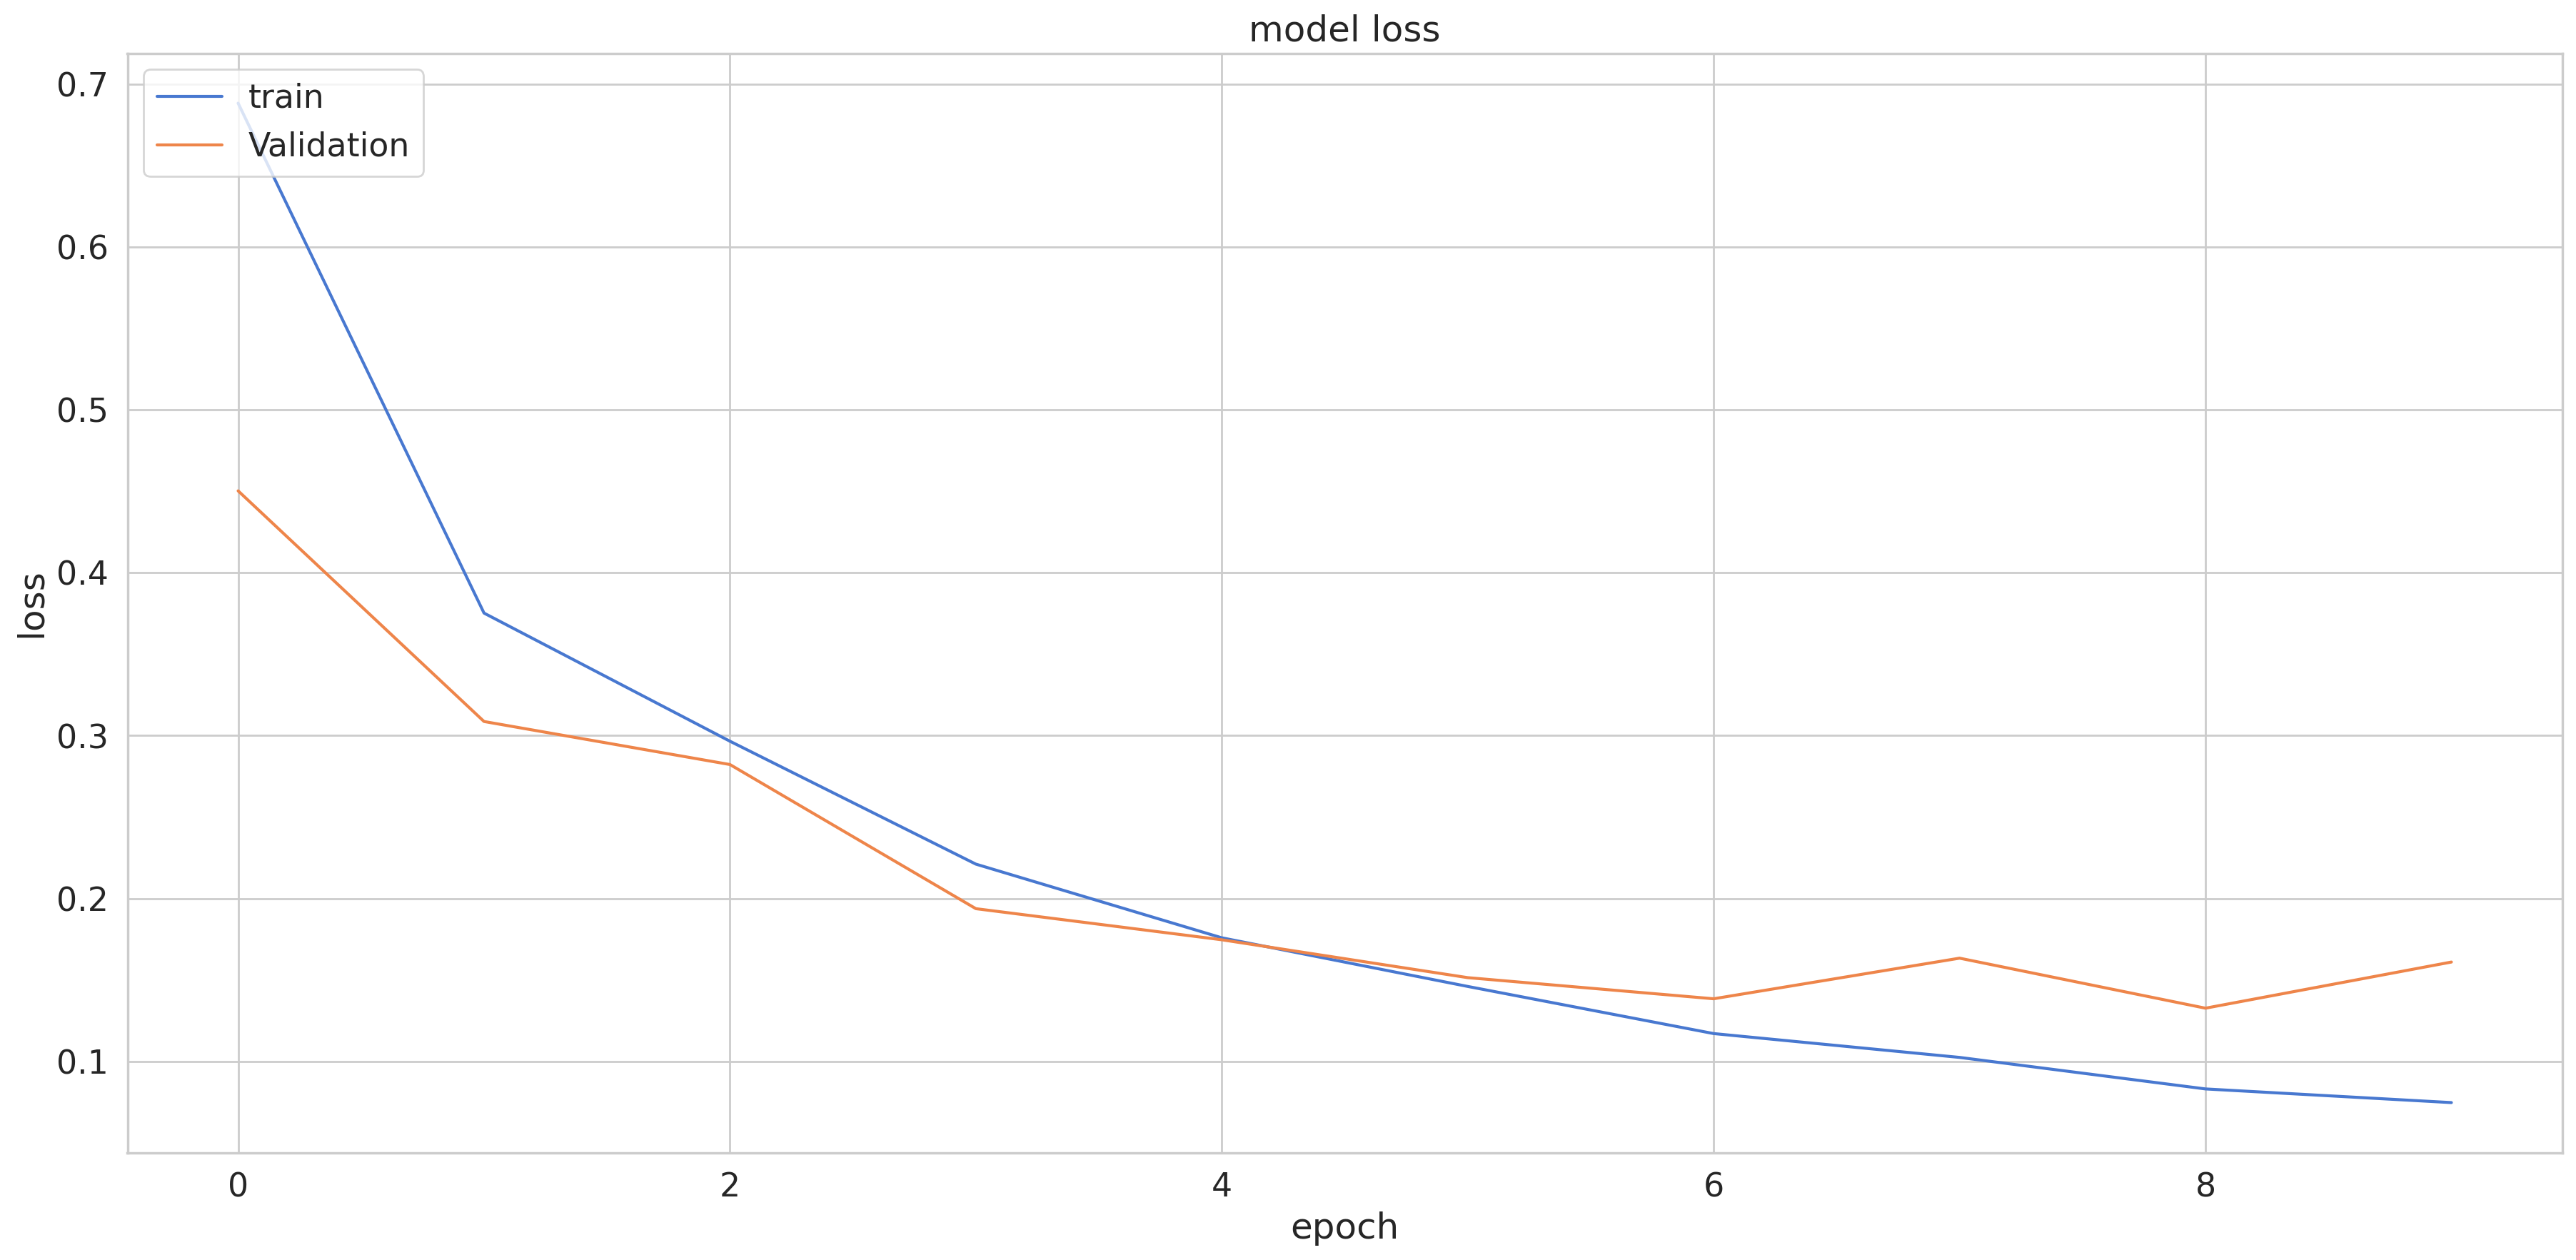

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

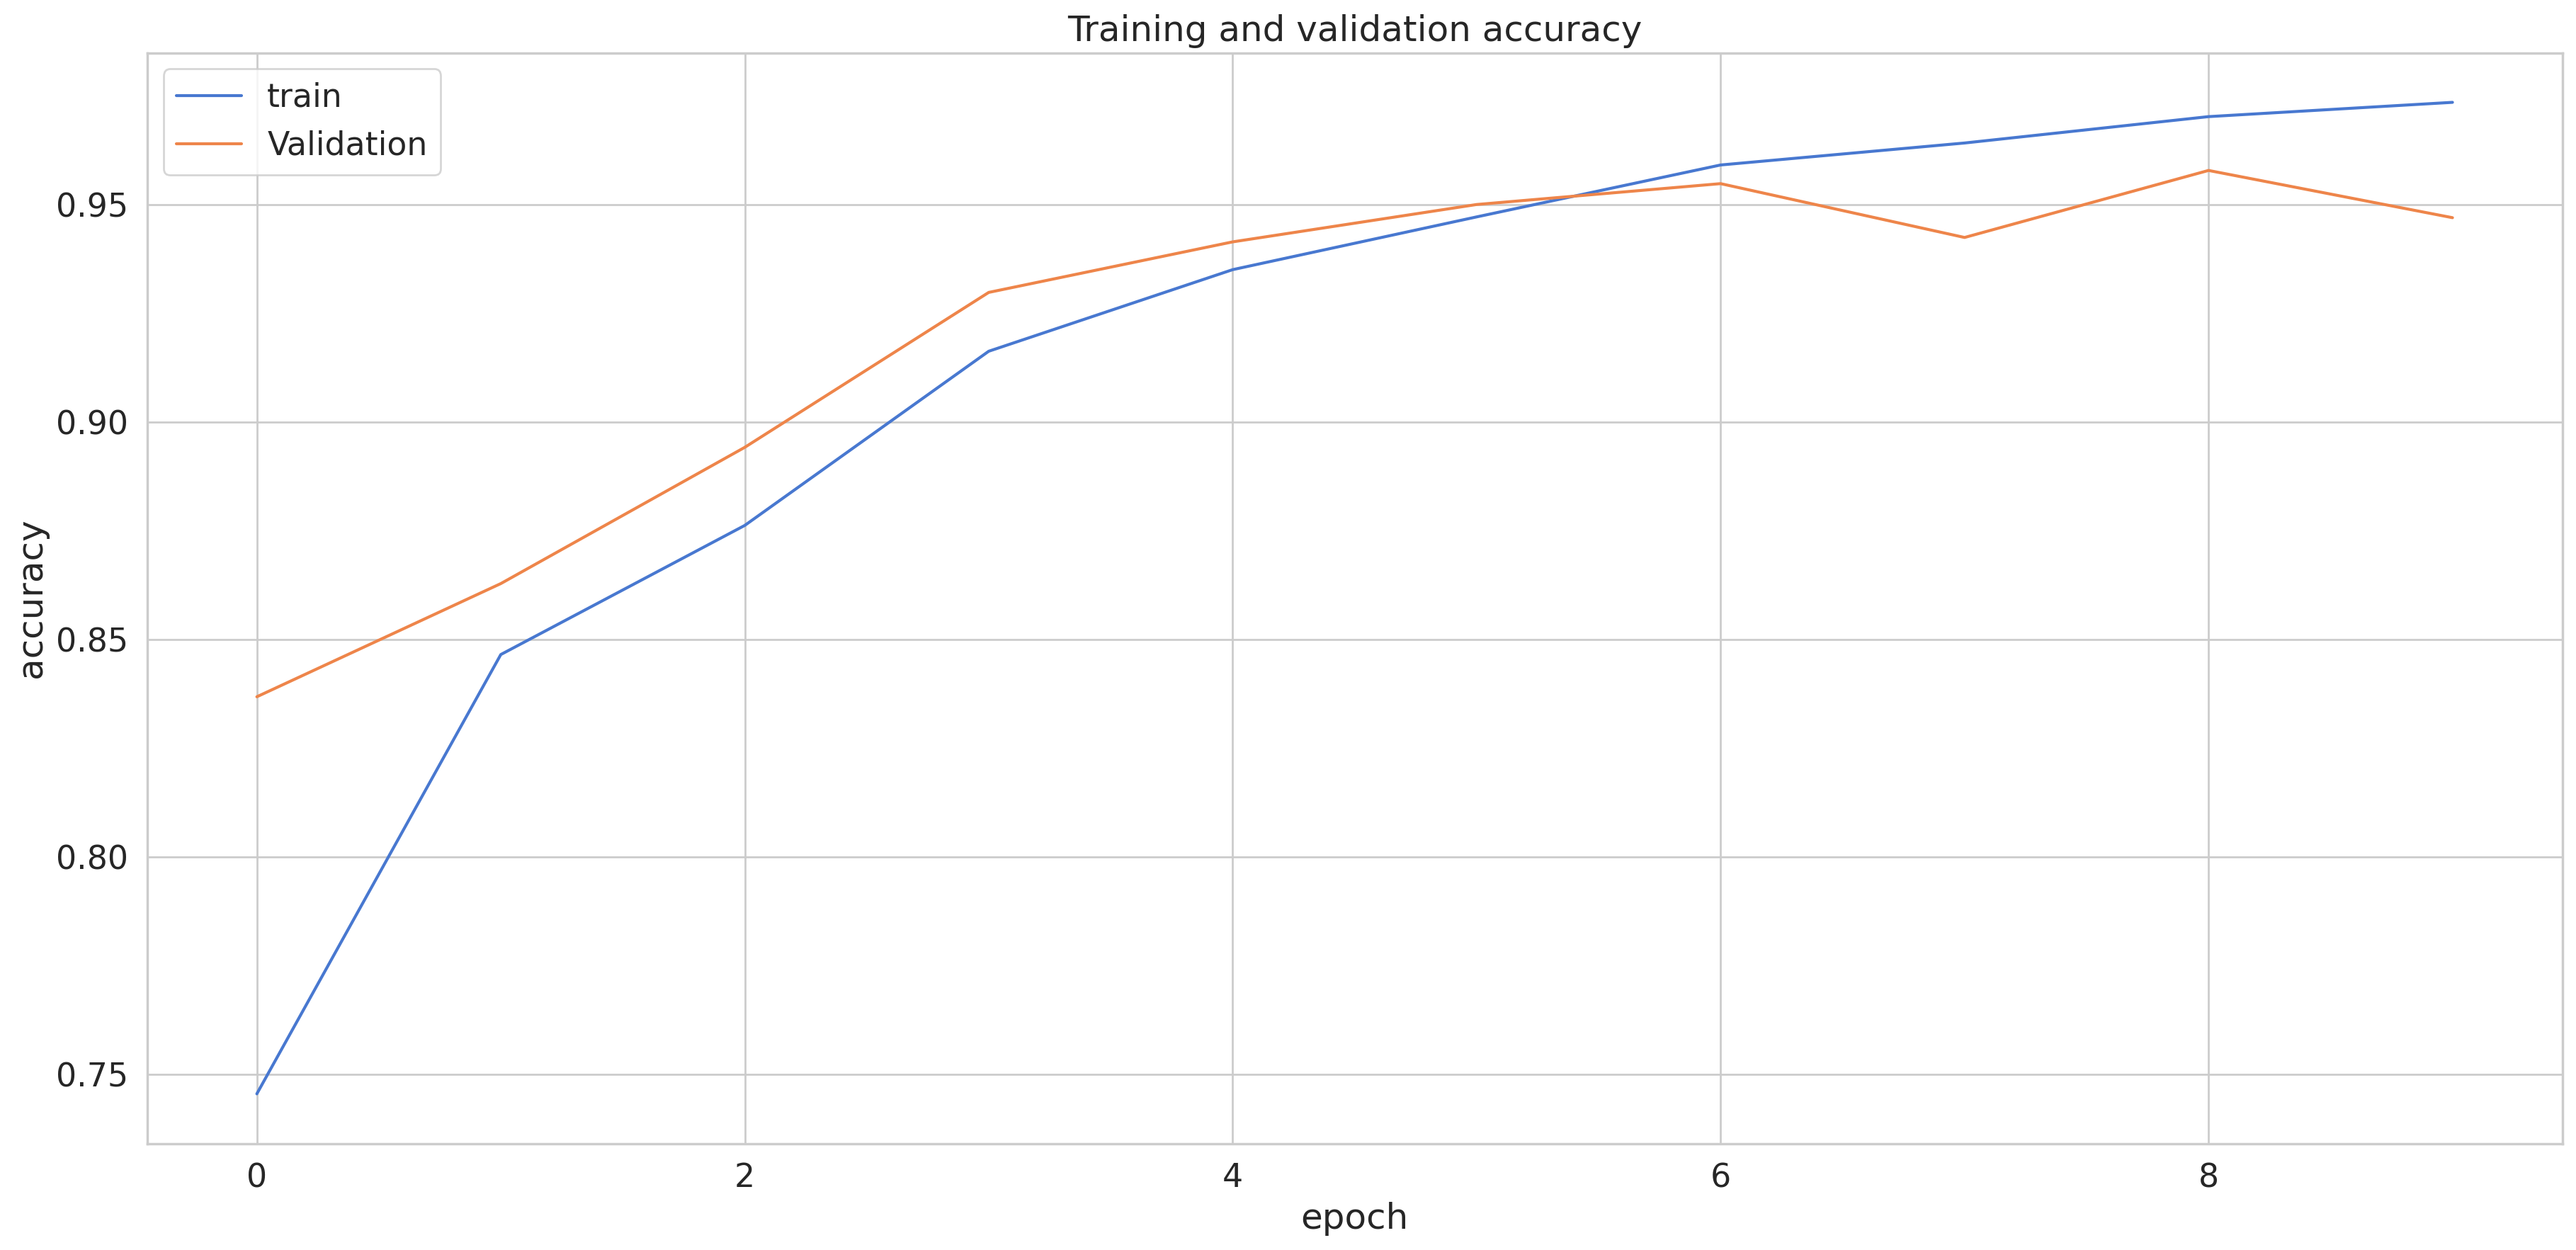

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

155/155 [==============================] - 2s 8ms/step
f1_score =  0.9550852377348167
0.9559506971105274
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2123
           1       0.98      0.99      0.99      1710
           2       0.96      0.72      0.82       615
           3       0.77      0.97      0.86       501

    accuracy                           0.96      4949
   macro avg       0.92      0.92      0.91      4949
weighted avg       0.96      0.96      0.96      4949



<Axes: >

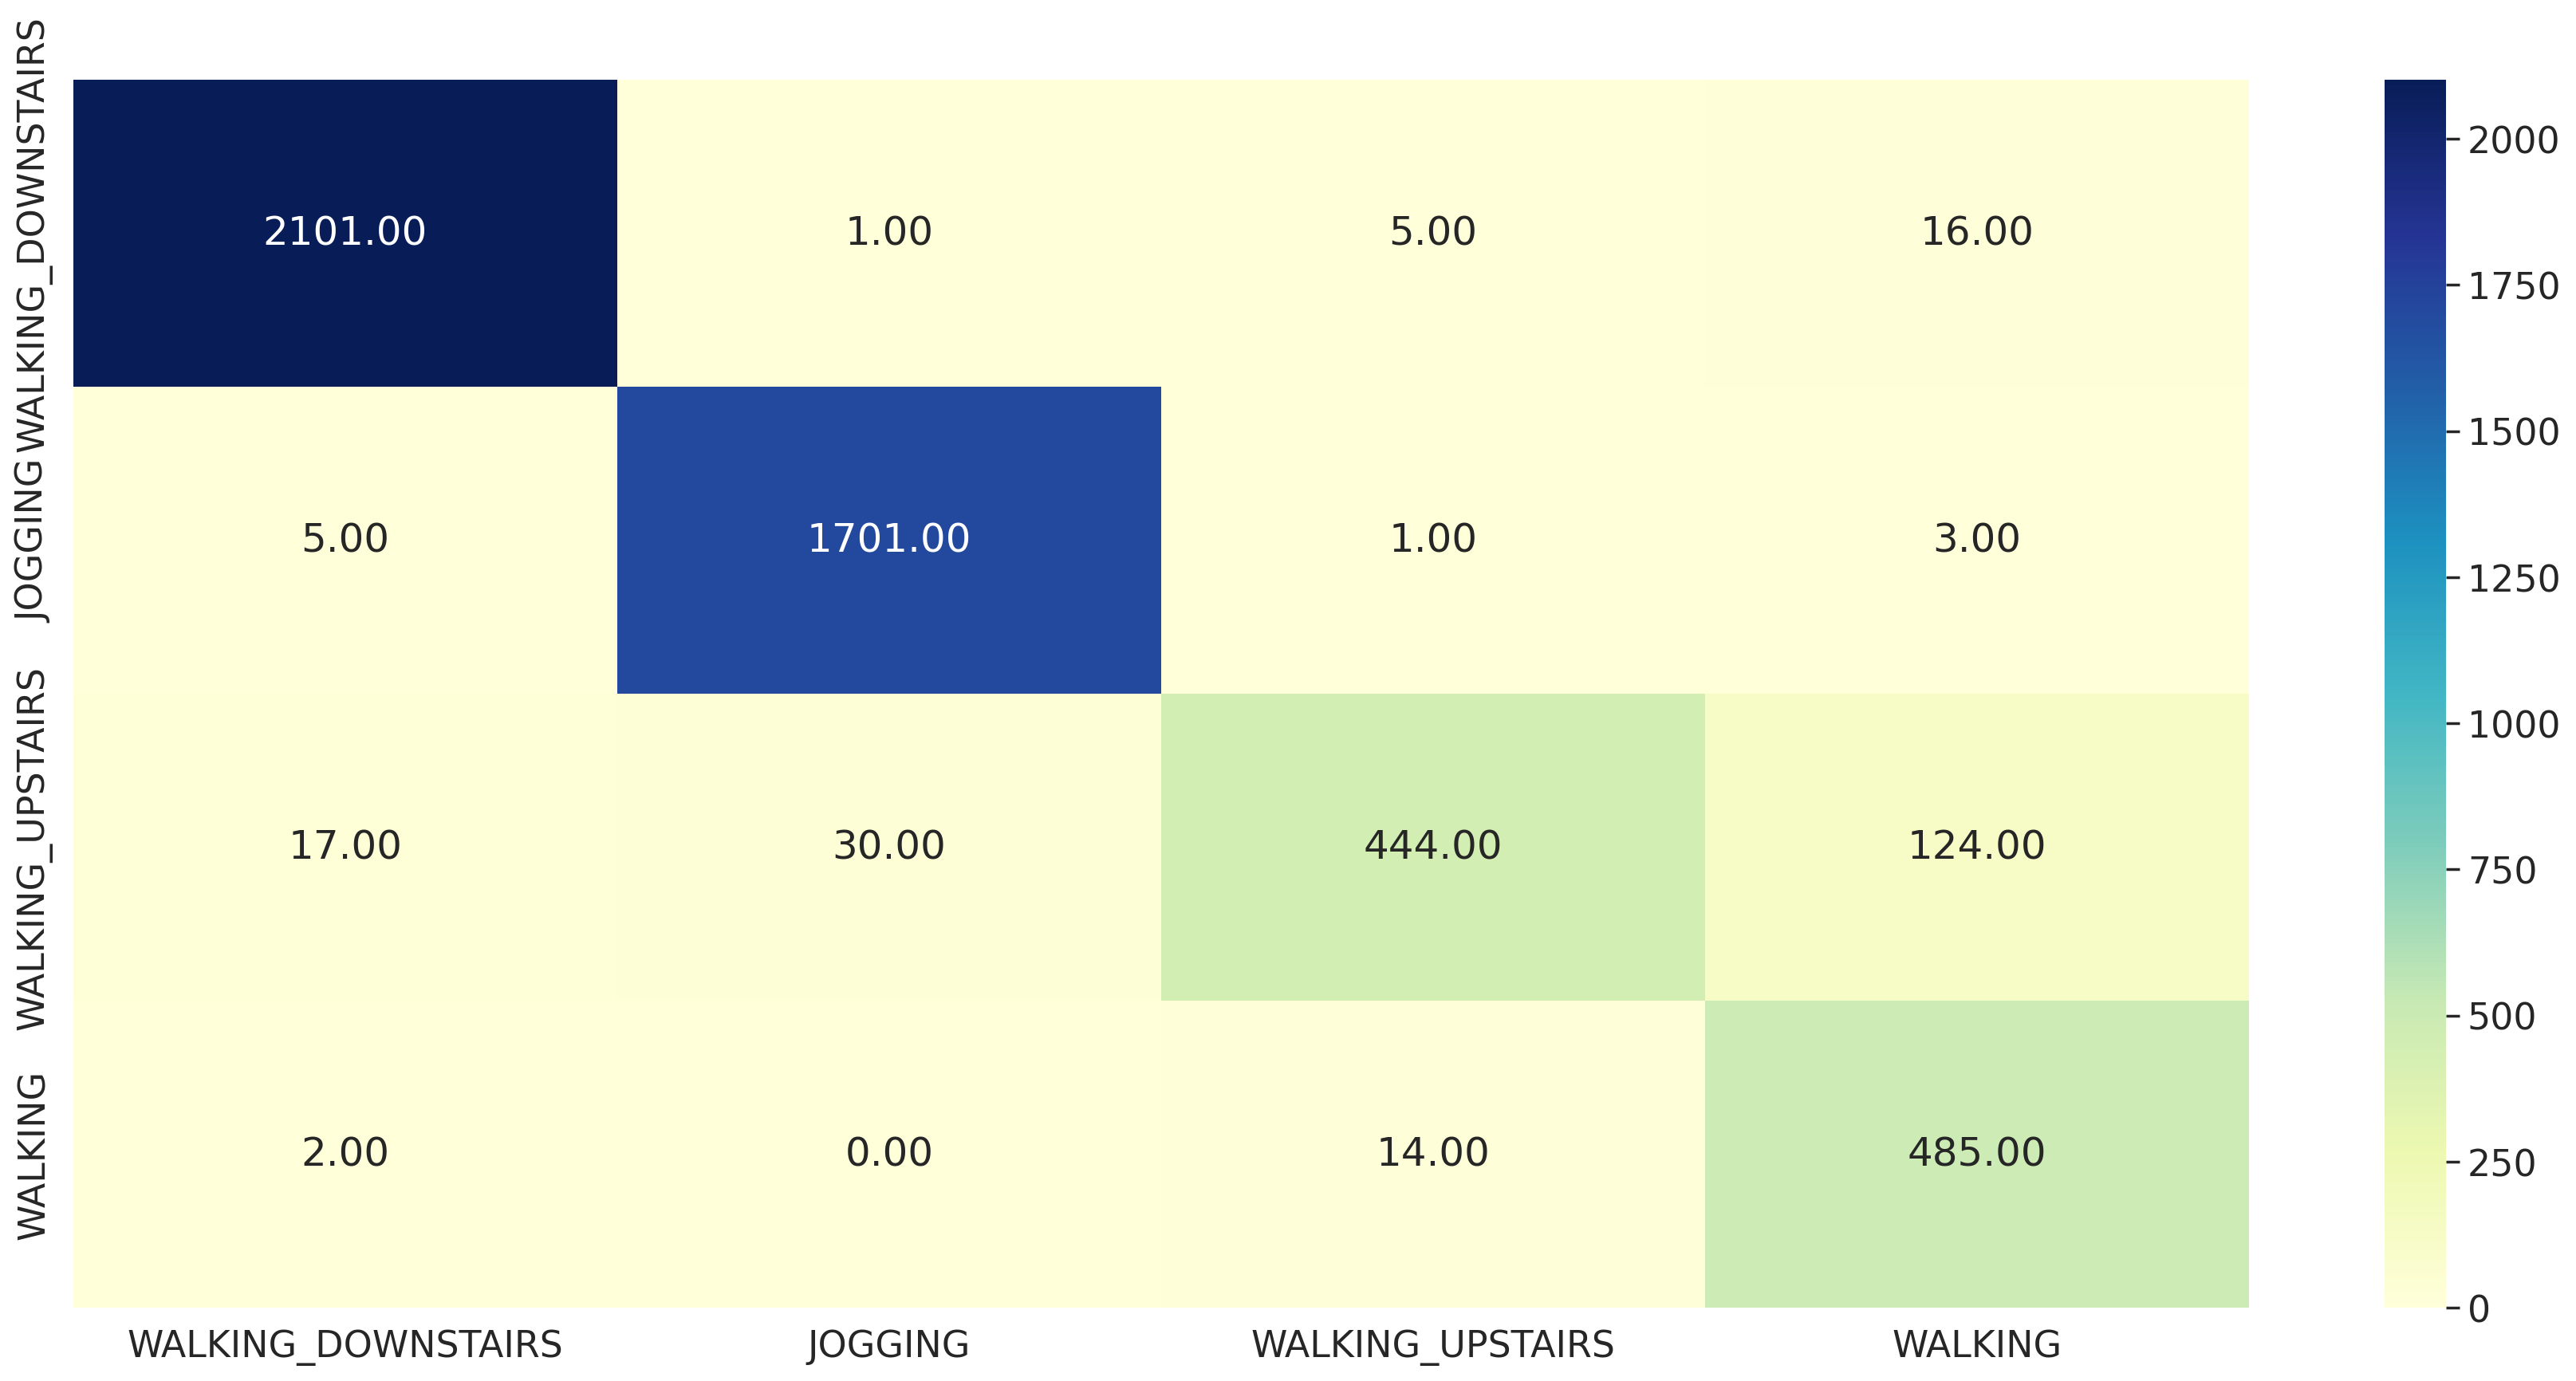

In [32]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['WALKING_DOWNSTAIRS','JOGGING','WALKING_UPSTAIRS','WALKING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2 - LSTM1

In [33]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))


model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDi  (None, None, 48, 64)      640       
 stributed)                                                      
                                                                 
 time_distributed_9 (TimeDi  (None, None, 46, 64)      12352     
 stributed)                                                      
                                                                 
 time_distributed_10 (TimeD  (None, None, 46, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, None, 23, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_12 (TimeD  (None, None, 1472)       

In [34]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
124/124 [==============================] - 24s 149ms/step - loss: 0.5834 - accuracy: 0.7733 - val_loss: 0.3174 - val_accuracy: 0.8740
Epoch 2/10
124/124 [==============================] - 16s 131ms/step - loss: 0.2864 - accuracy: 0.8844 - val_loss: 0.2421 - val_accuracy: 0.8977
Epoch 3/10
124/124 [==============================] - 17s 134ms/step - loss: 0.2012 - accuracy: 0.9228 - val_loss: 0.2071 - val_accuracy: 0.9207
Epoch 4/10
124/124 [==============================] - 17s 134ms/step - loss: 0.1494 - accuracy: 0.9479 - val_loss: 0.1627 - val_accuracy: 0.9465
Epoch 5/10
124/124 [==============================] - 16s 130ms/step - loss: 0.1122 - accuracy: 0.9611 - val_loss: 0.1453 - val_accuracy: 0.9518
Epoch 6/10
124/124 [==============================] - 17s 134ms/step - loss: 0.1032 - accuracy: 0.9644 - val_loss: 0.1387 - val_accuracy: 0.9475
Epoch 7/10
124/124 [==============================] - 19s 149ms/step - loss: 0.0865 - accuracy: 0.9697 - val_loss: 0.1182 - val_ac

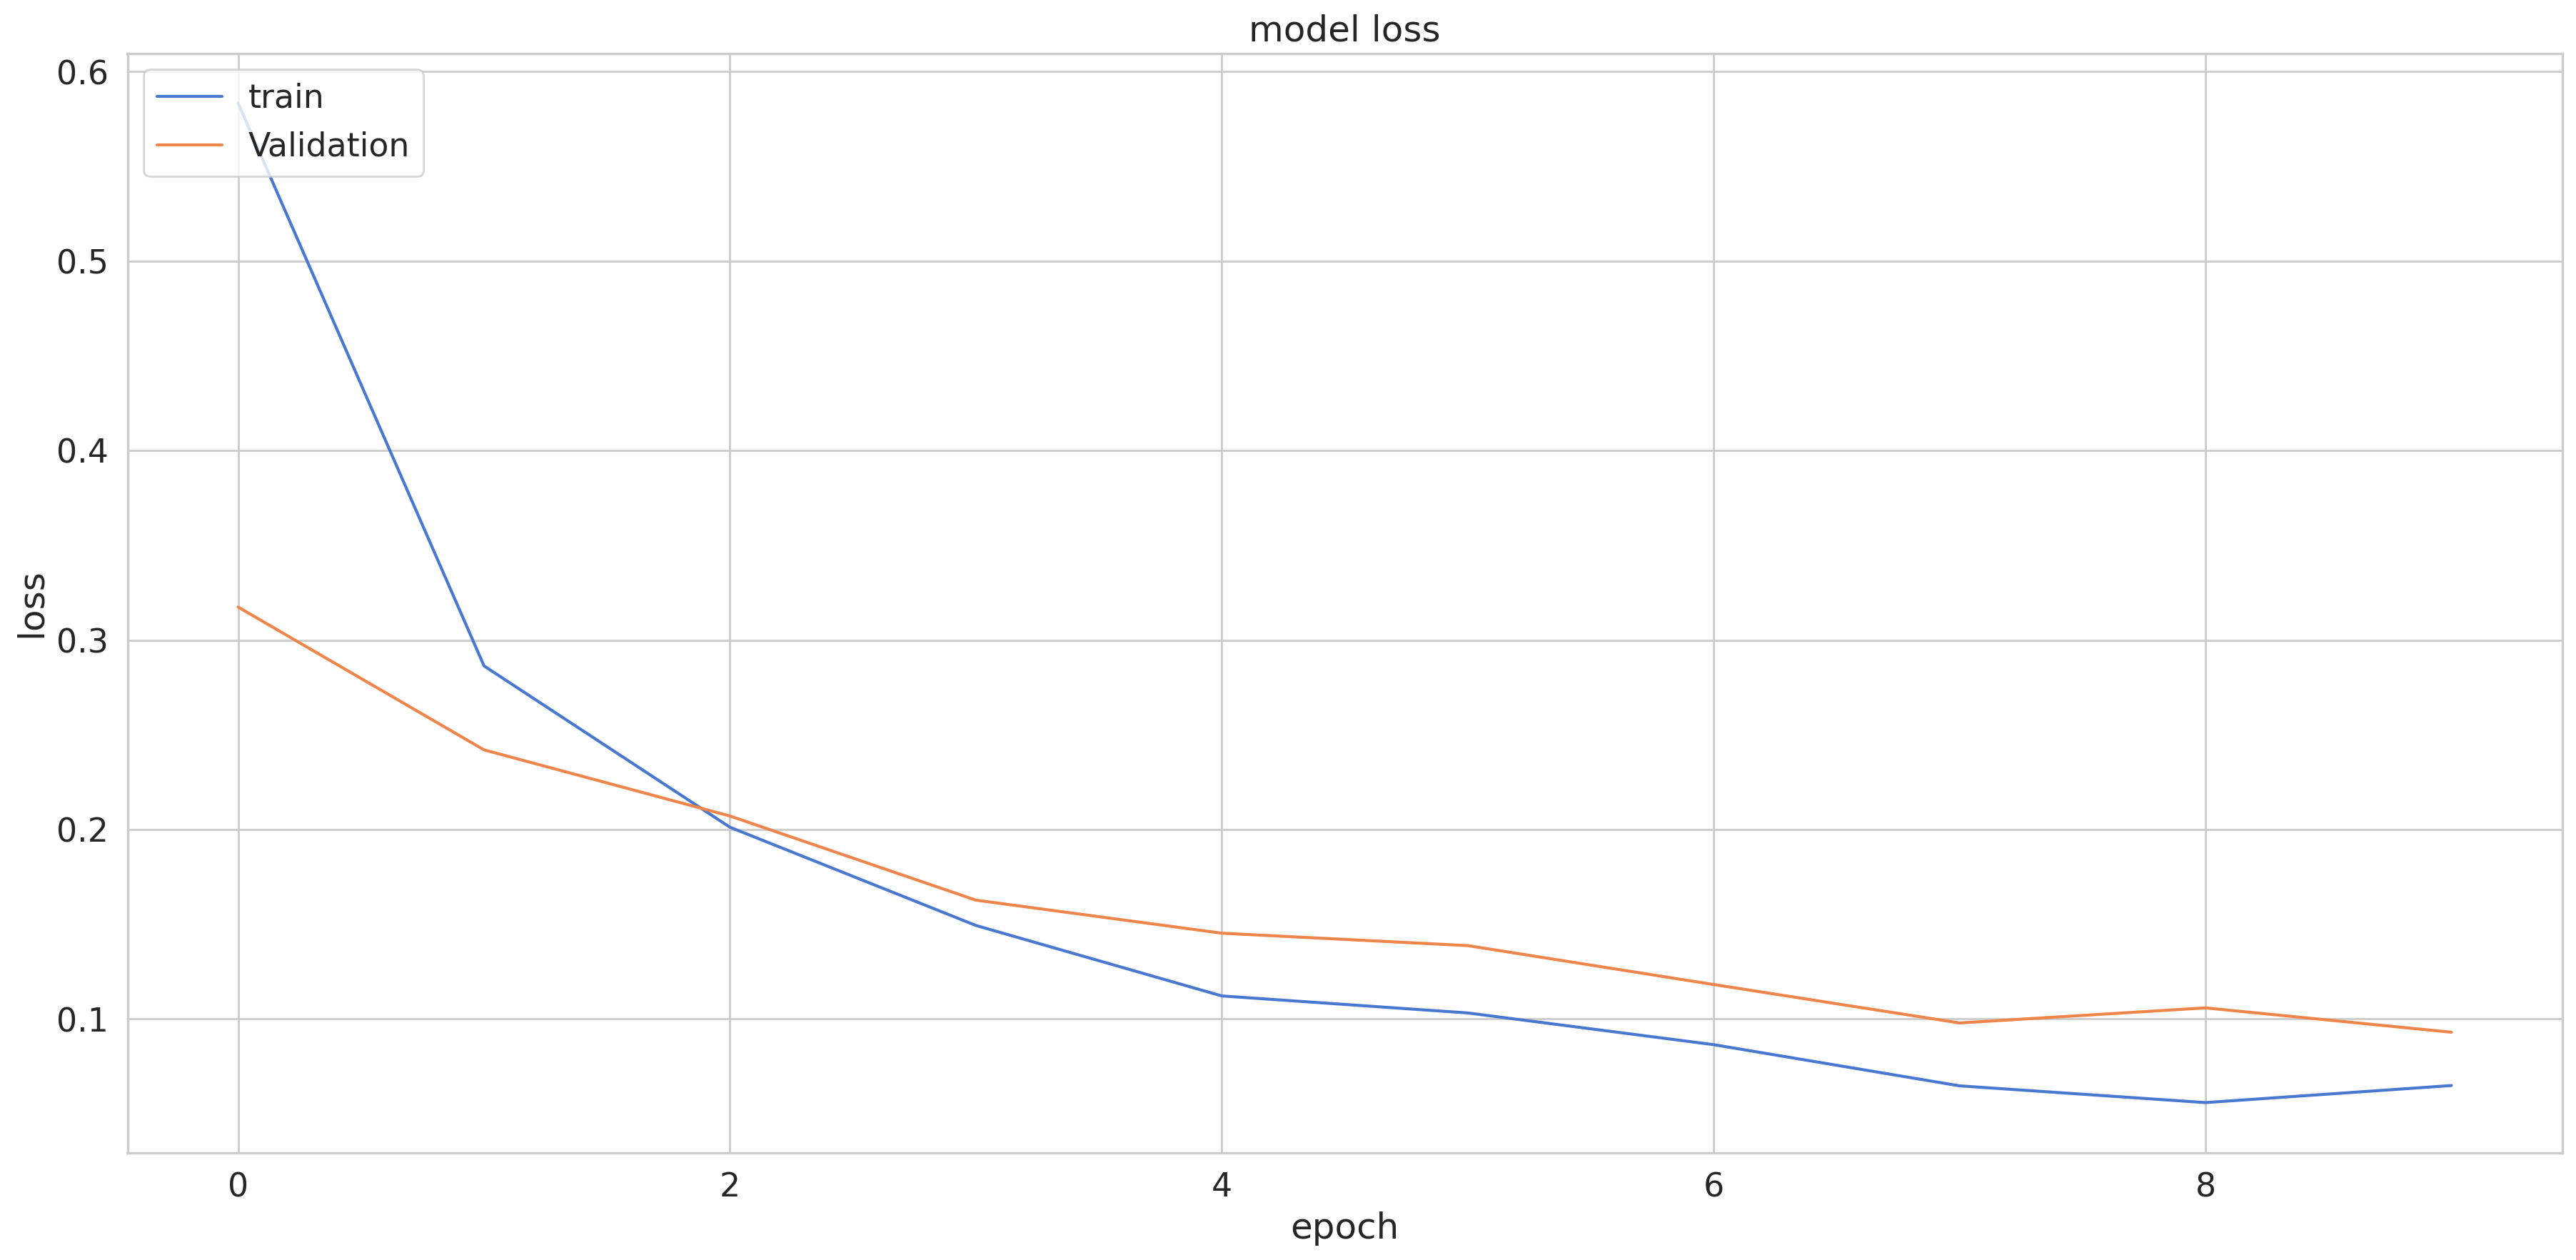

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

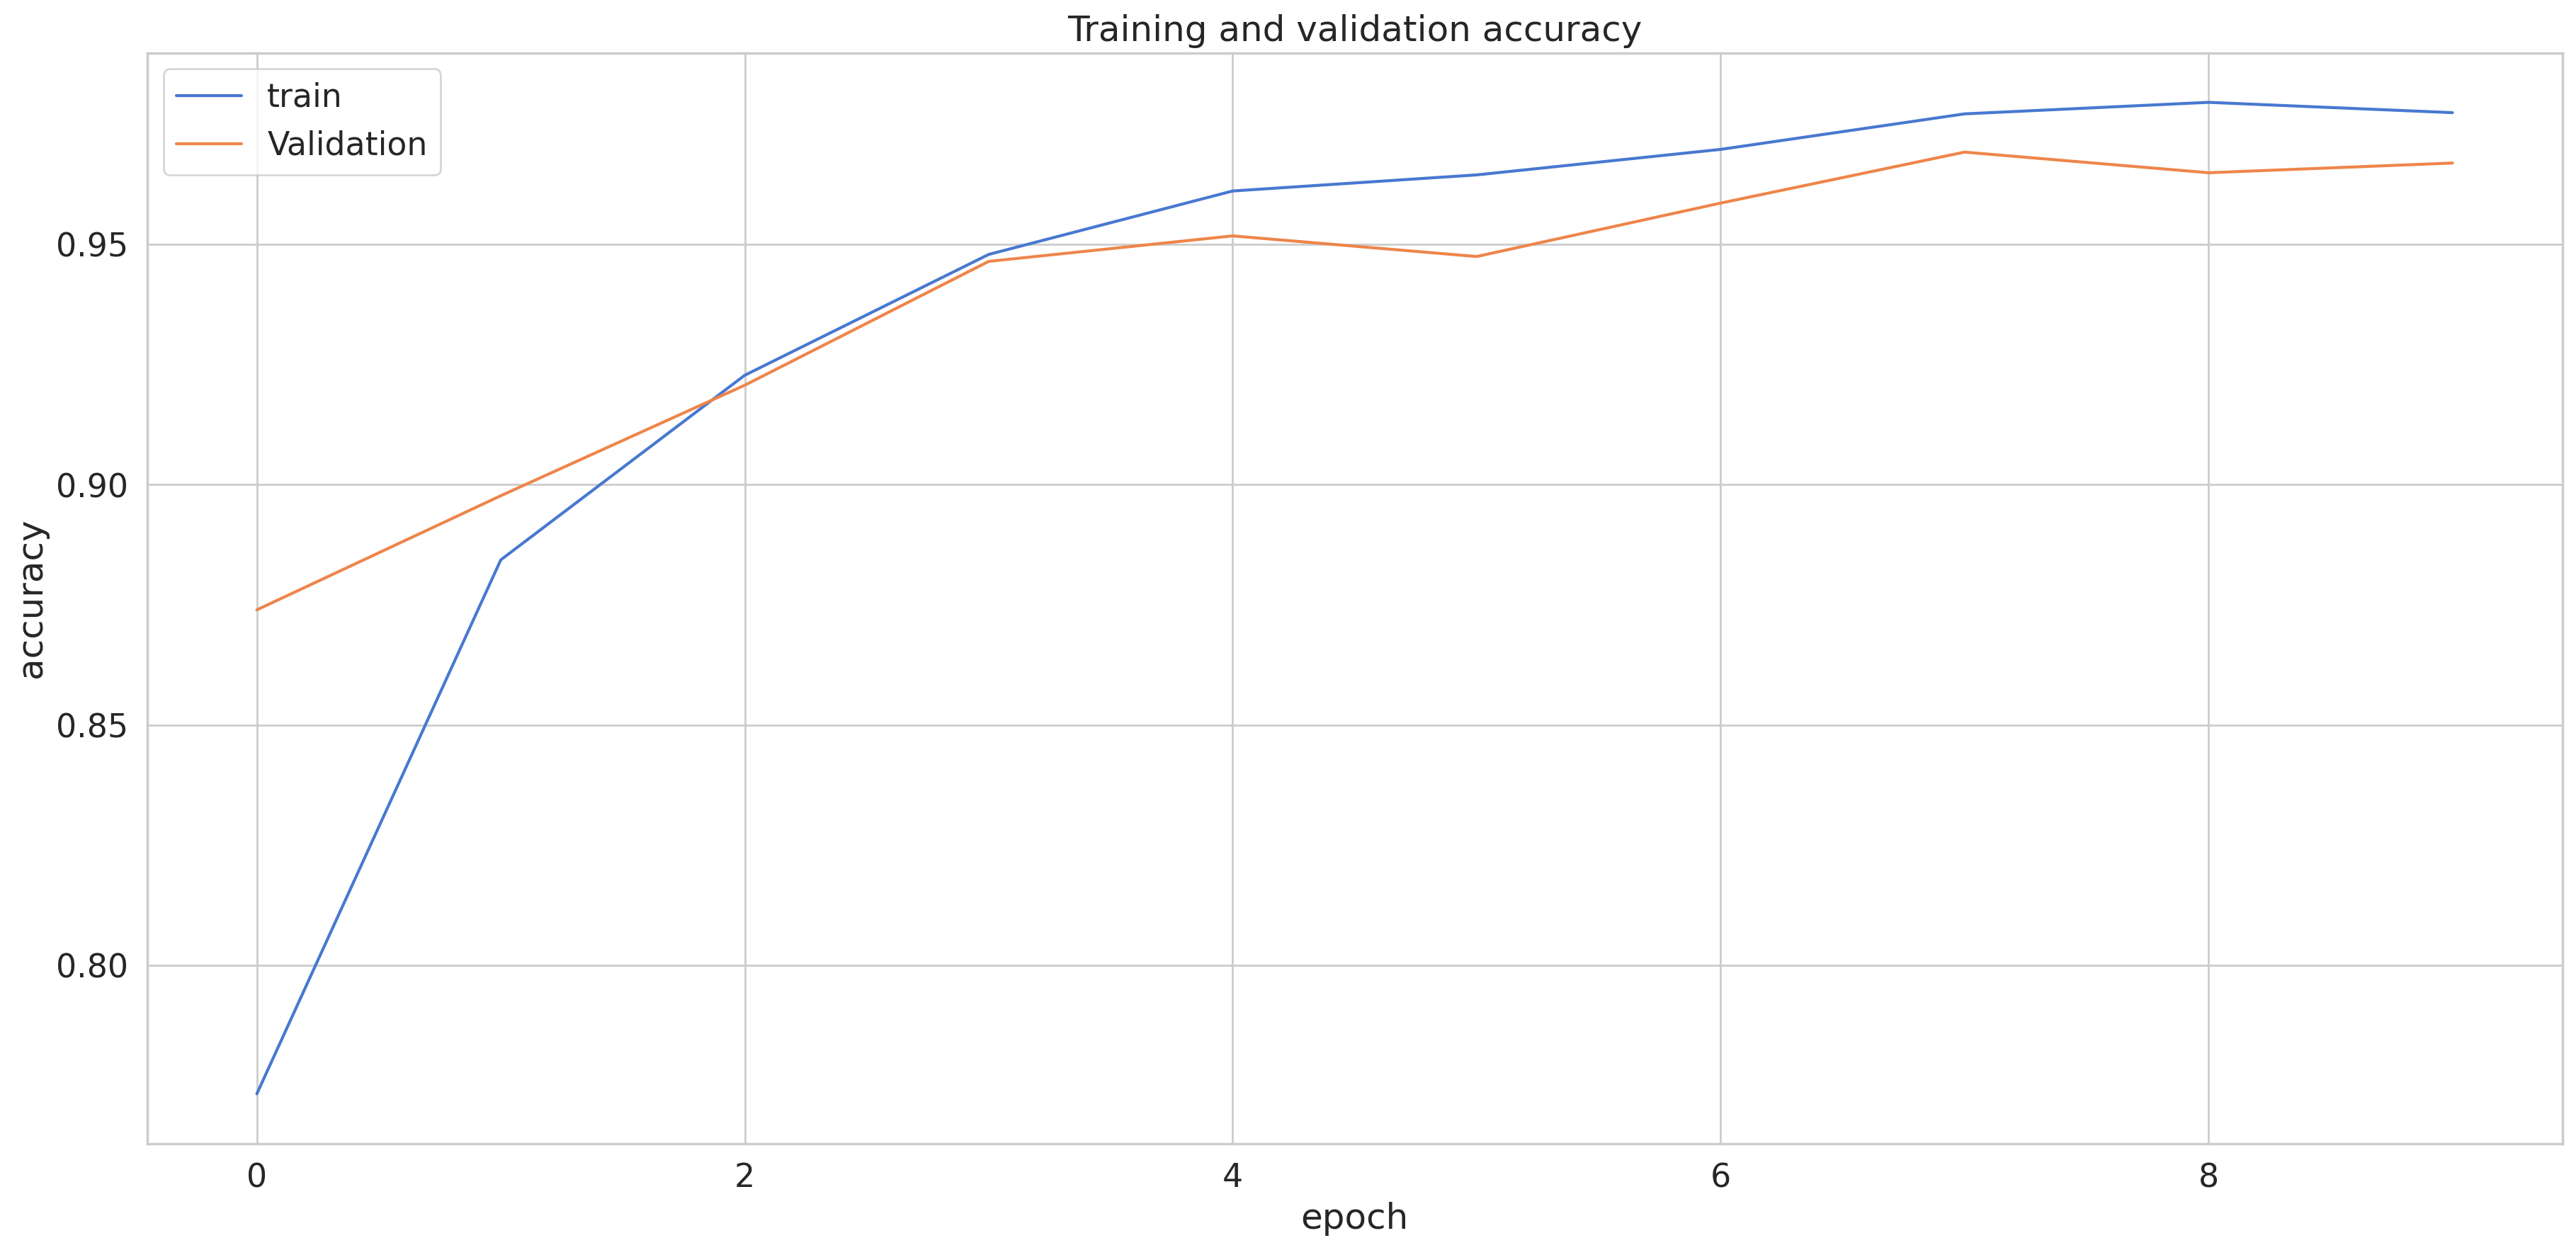

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

155/155 [==============================] - 2s 10ms/step
f1_score =  0.9752019669690679
0.9751464942412609
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2123
           1       0.99      0.99      0.99      1710
           2       0.88      0.95      0.91       615
           3       0.95      0.88      0.91       501

    accuracy                           0.98      4949
   macro avg       0.96      0.95      0.95      4949
weighted avg       0.98      0.98      0.98      4949



<Axes: >

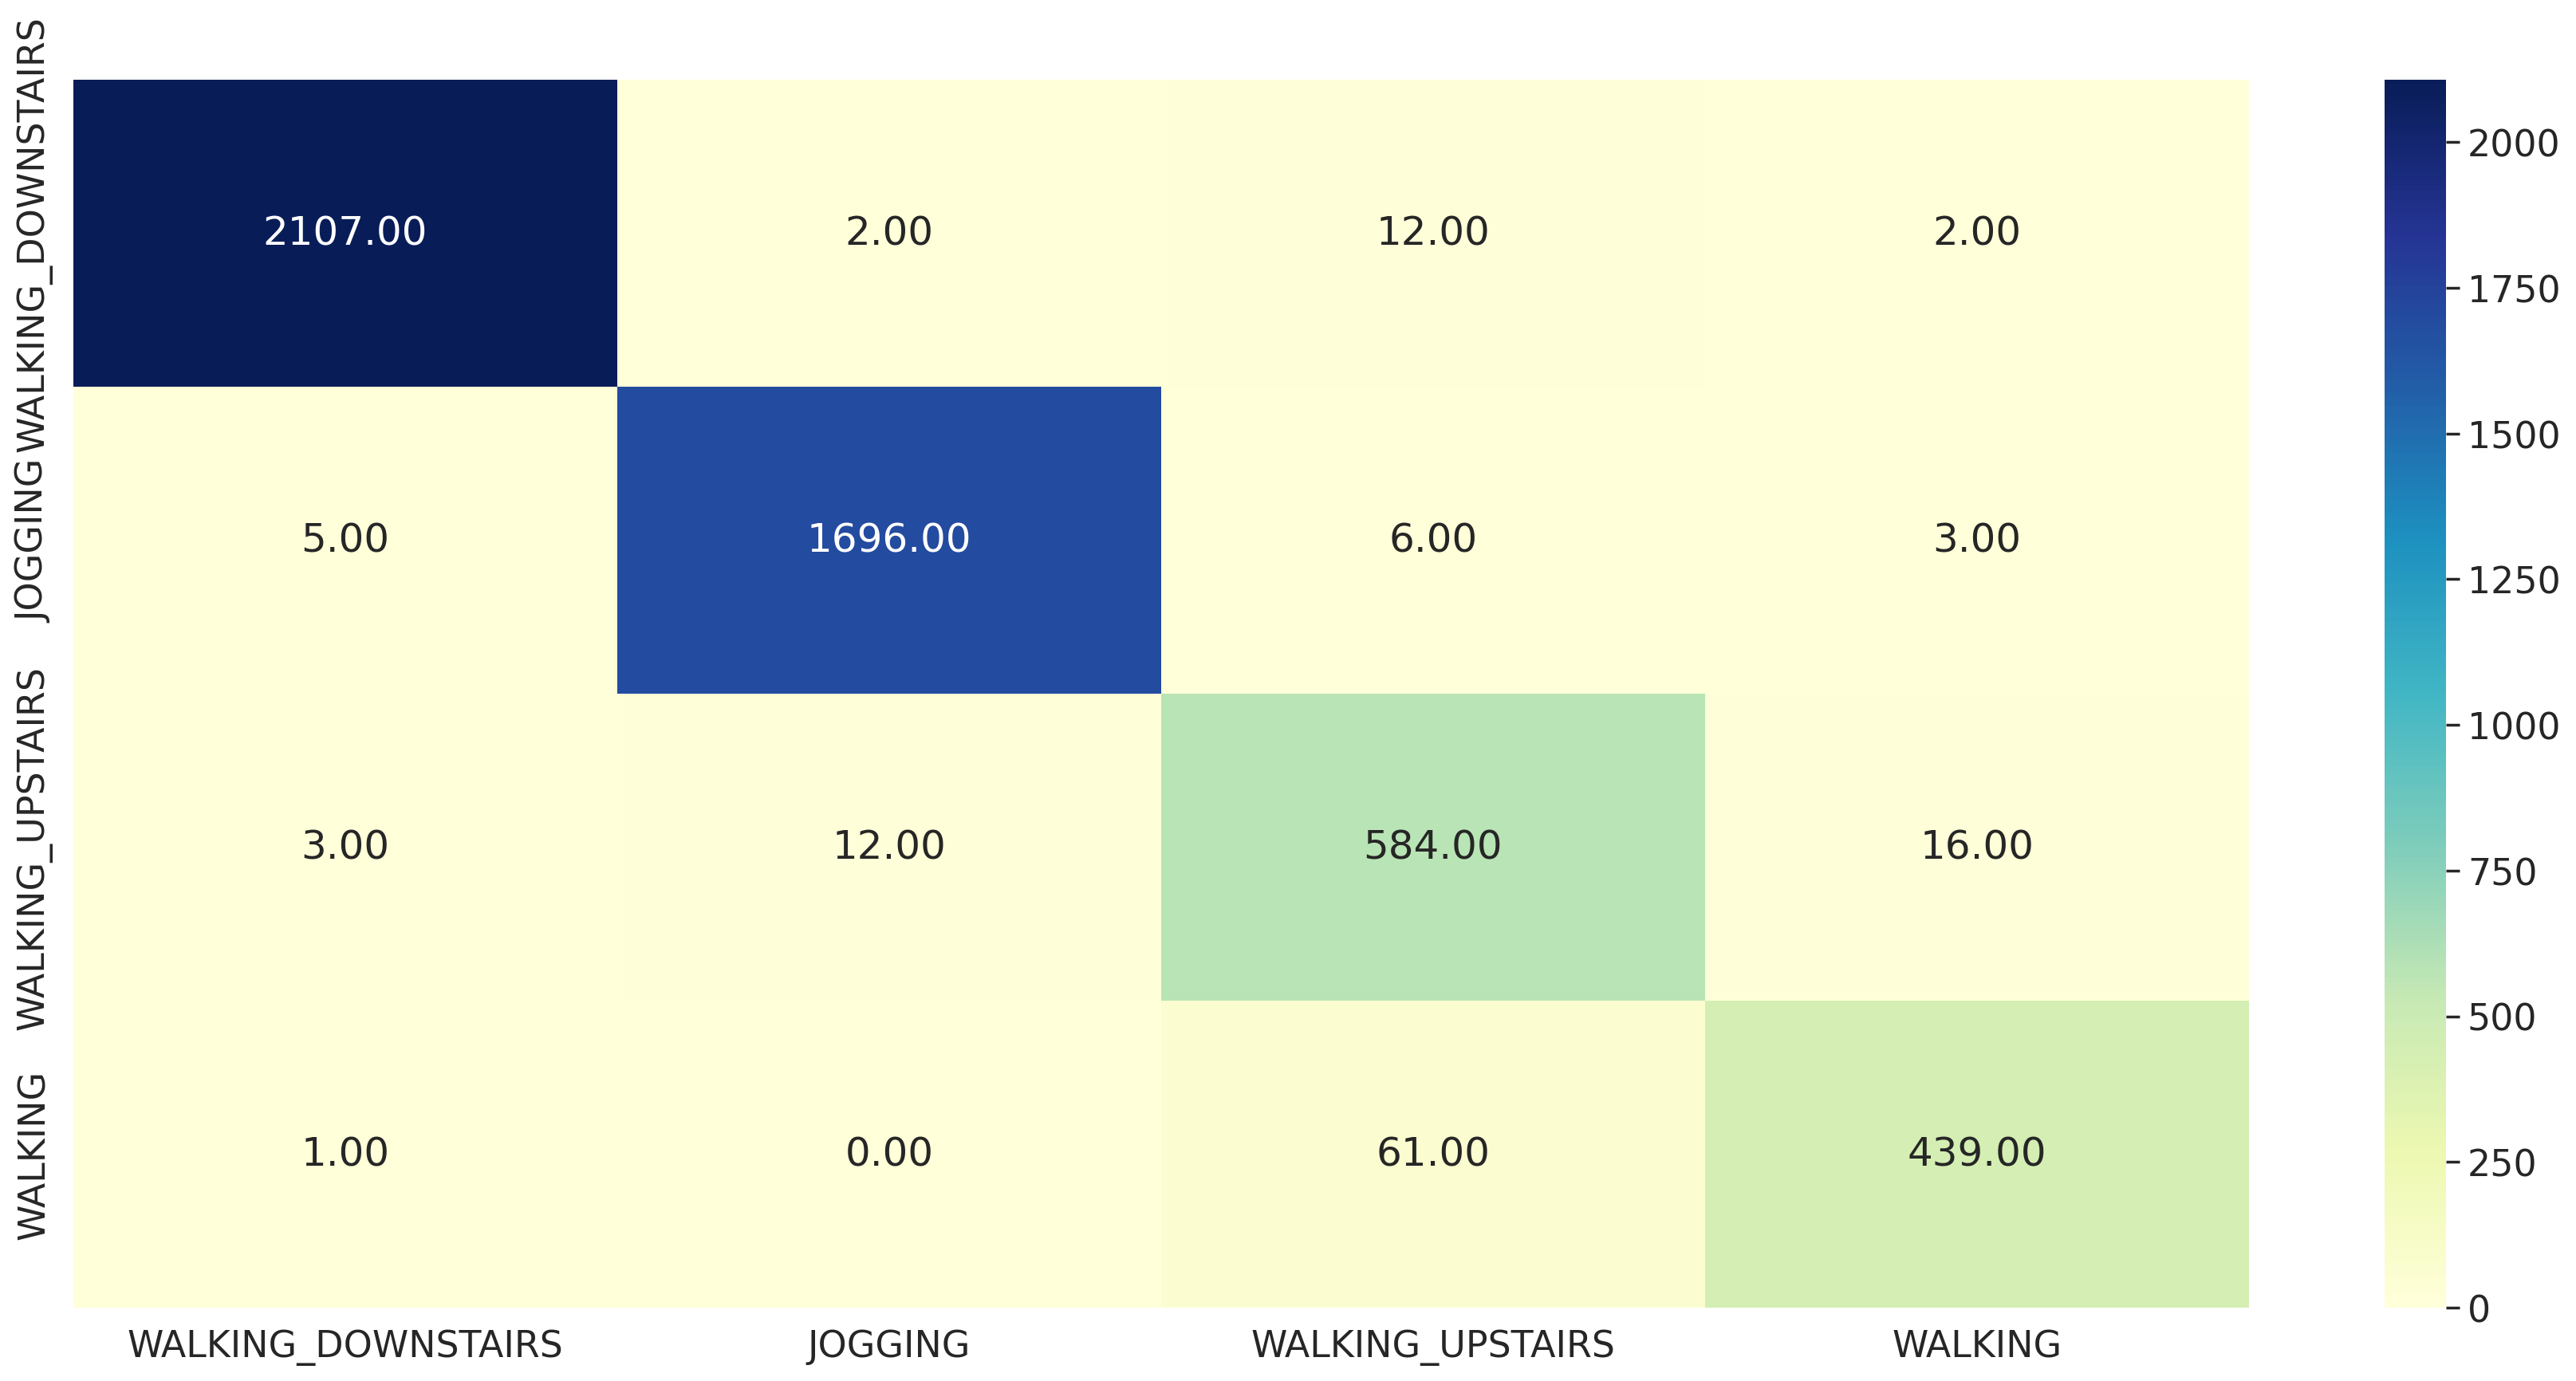

In [37]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['WALKING_DOWNSTAIRS','JOGGING','WALKING_UPSTAIRS','WALKING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

# CNN2 - LSTM2

In [38]:

# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(100,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeD  (None, None, 48, 64)      640       
 istributed)                                                     
                                                                 
 time_distributed_14 (TimeD  (None, None, 46, 64)      12352     
 istributed)                                                     
                                                                 
 time_distributed_15 (TimeD  (None, None, 46, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_16 (TimeD  (None, None, 23, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_17 (TimeD  (None, None, 1472)       

In [39]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(X_train, y_train_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_hot), shuffle=True)


Epoch 1/10
124/124 [==============================] - 28s 155ms/step - loss: 0.6288 - accuracy: 0.7550 - val_loss: 0.3338 - val_accuracy: 0.8631
Epoch 2/10
124/124 [==============================] - 20s 160ms/step - loss: 0.2976 - accuracy: 0.8729 - val_loss: 0.2371 - val_accuracy: 0.8969
Epoch 3/10
124/124 [==============================] - 18s 144ms/step - loss: 0.2142 - accuracy: 0.9142 - val_loss: 0.1731 - val_accuracy: 0.9358
Epoch 4/10
124/124 [==============================] - 18s 145ms/step - loss: 0.1494 - accuracy: 0.9460 - val_loss: 0.1461 - val_accuracy: 0.9475
Epoch 5/10
124/124 [==============================] - 20s 164ms/step - loss: 0.1262 - accuracy: 0.9568 - val_loss: 0.1176 - val_accuracy: 0.9578
Epoch 6/10
124/124 [==============================] - 18s 144ms/step - loss: 0.0994 - accuracy: 0.9649 - val_loss: 0.1399 - val_accuracy: 0.9530
Epoch 7/10
124/124 [==============================] - 19s 154ms/step - loss: 0.0823 - accuracy: 0.9725 - val_loss: 0.1129 - val_ac

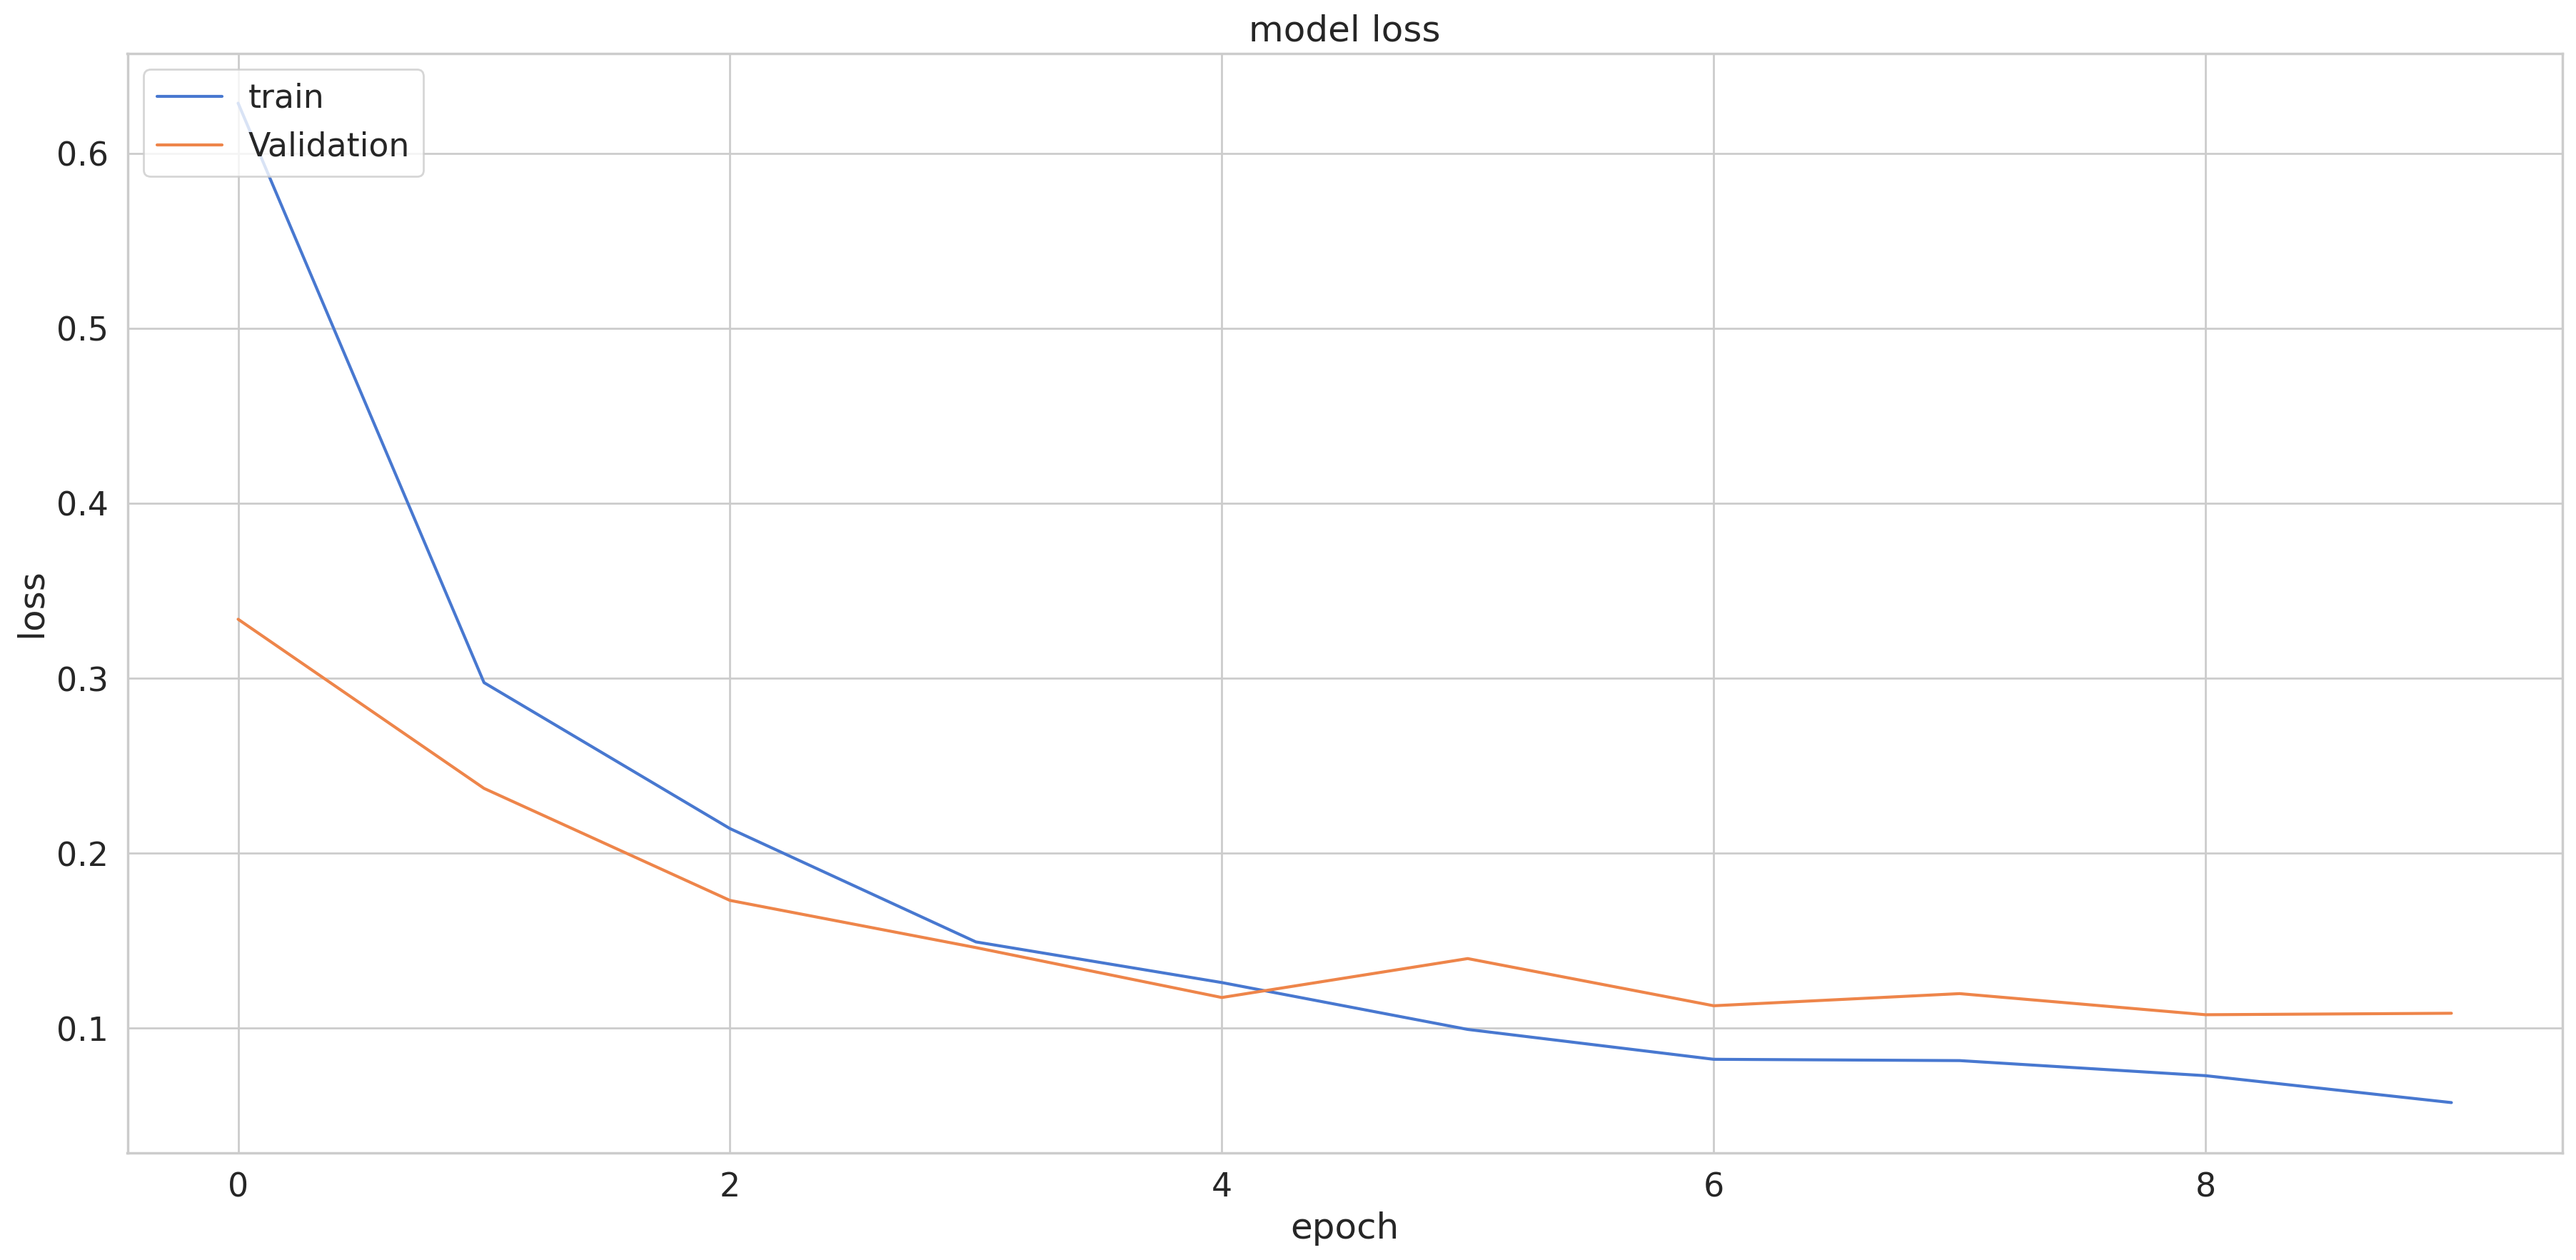

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

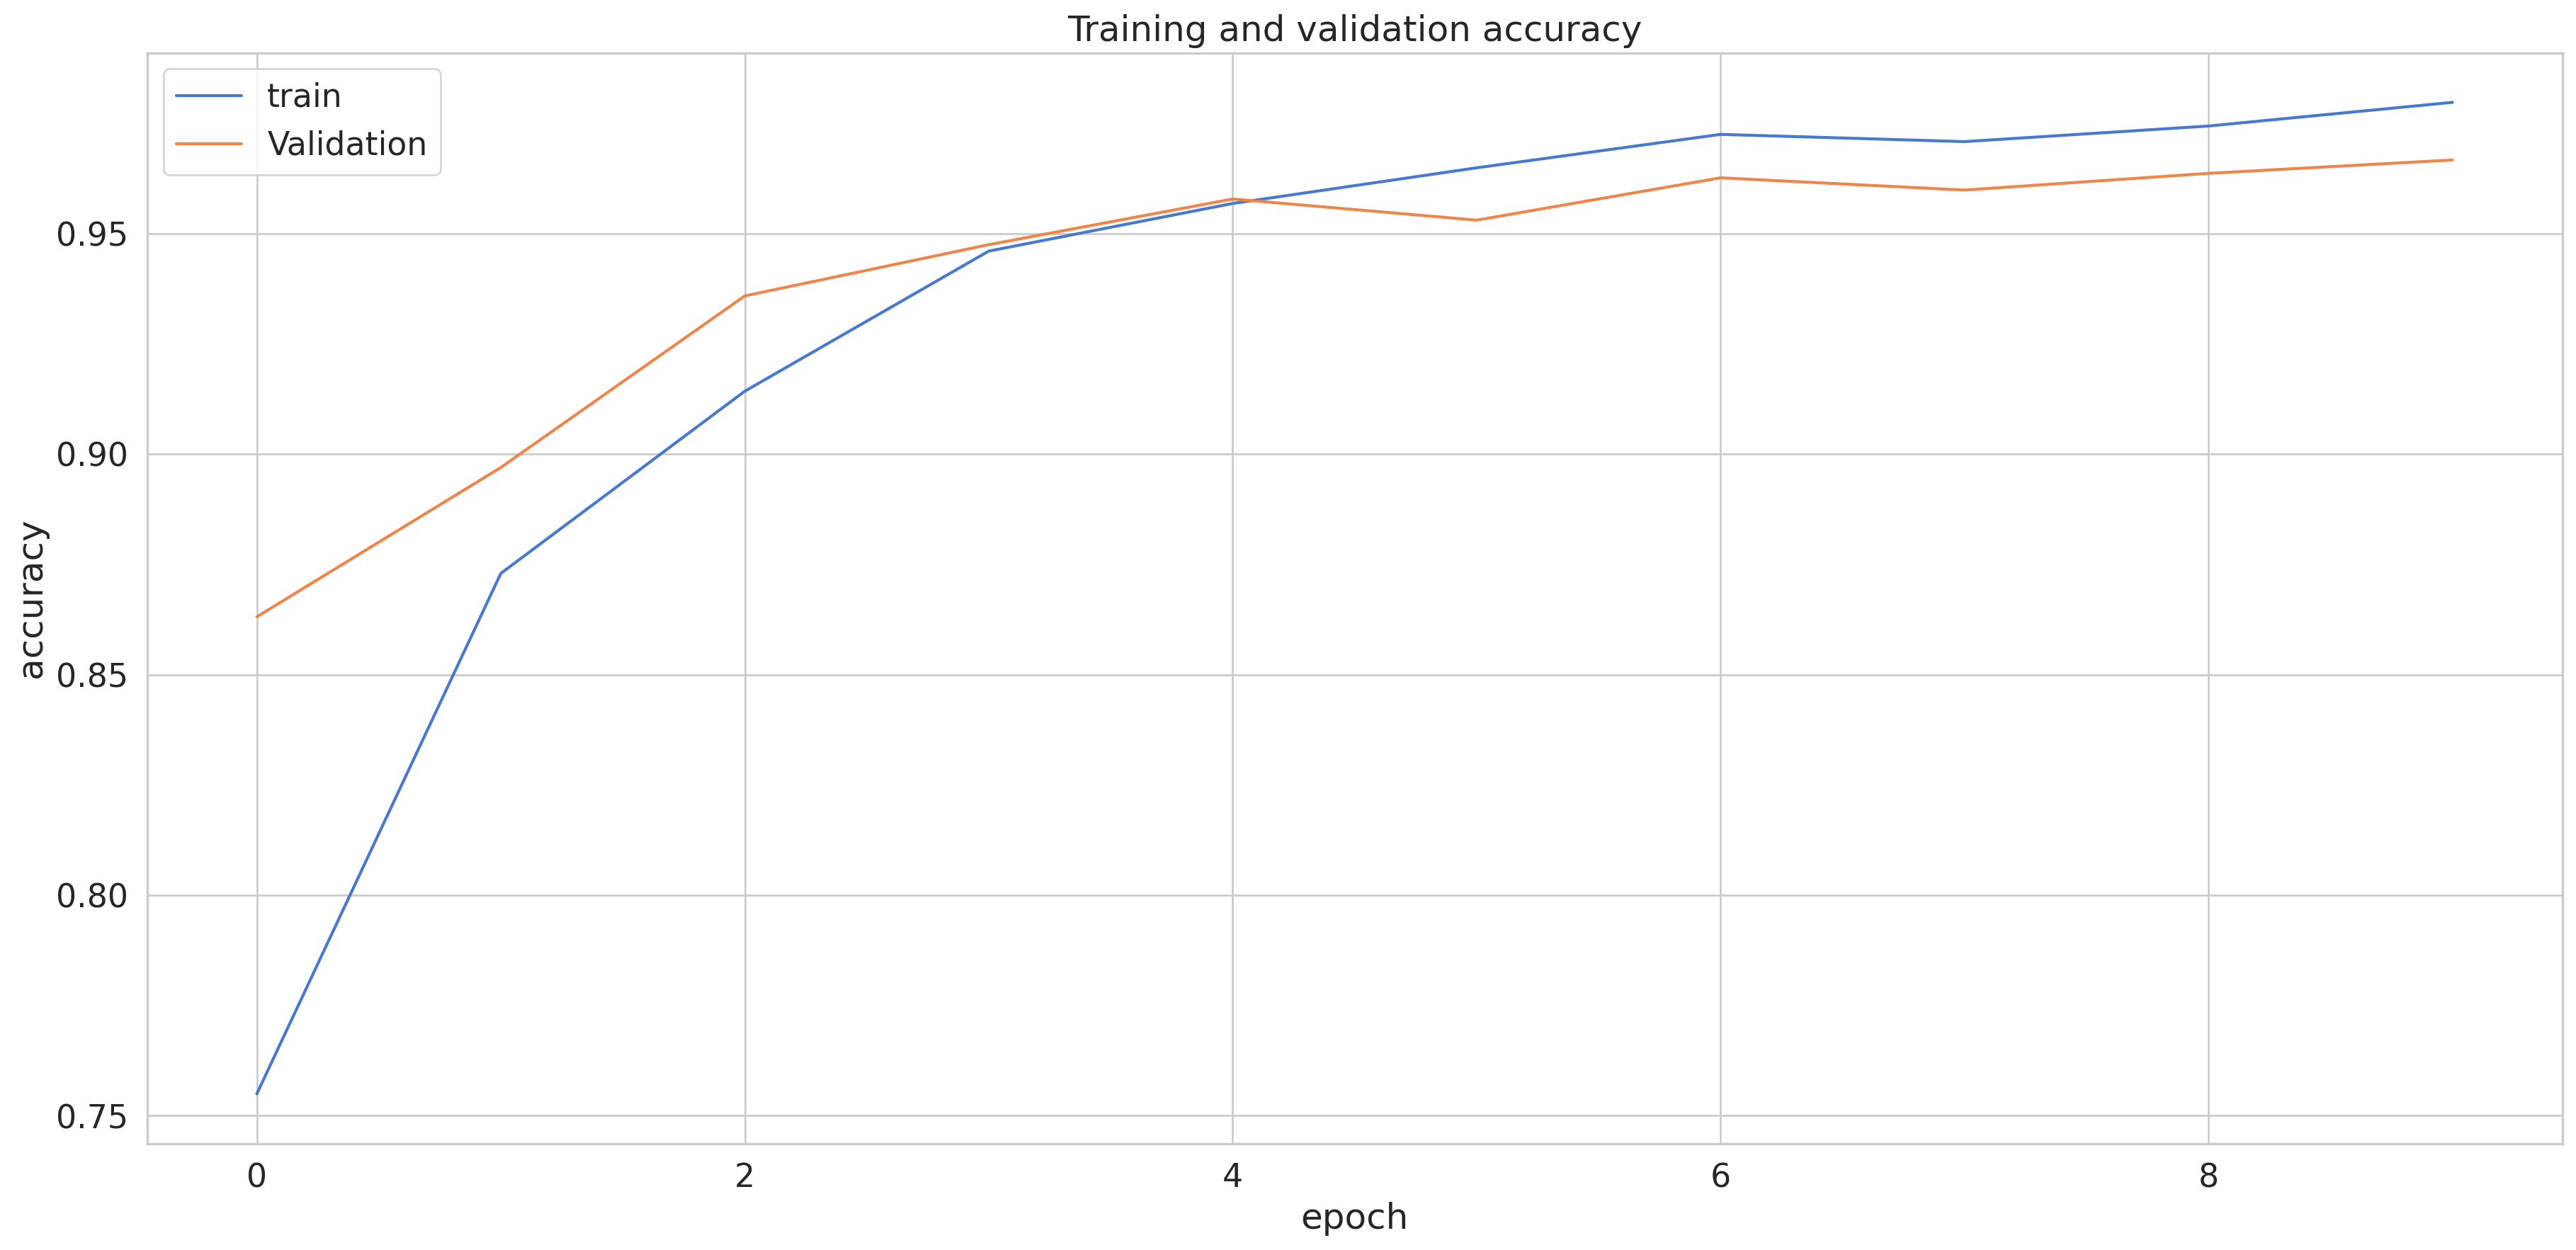

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

155/155 [==============================] - 4s 18ms/step
f1_score =  0.9739753233825611
0.9739341281066882
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2123
           1       0.99      1.00      0.99      1710
           2       0.93      0.89      0.91       615
           3       0.88      0.94      0.91       501

    accuracy                           0.97      4949
   macro avg       0.95      0.95      0.95      4949
weighted avg       0.97      0.97      0.97      4949



<Axes: >

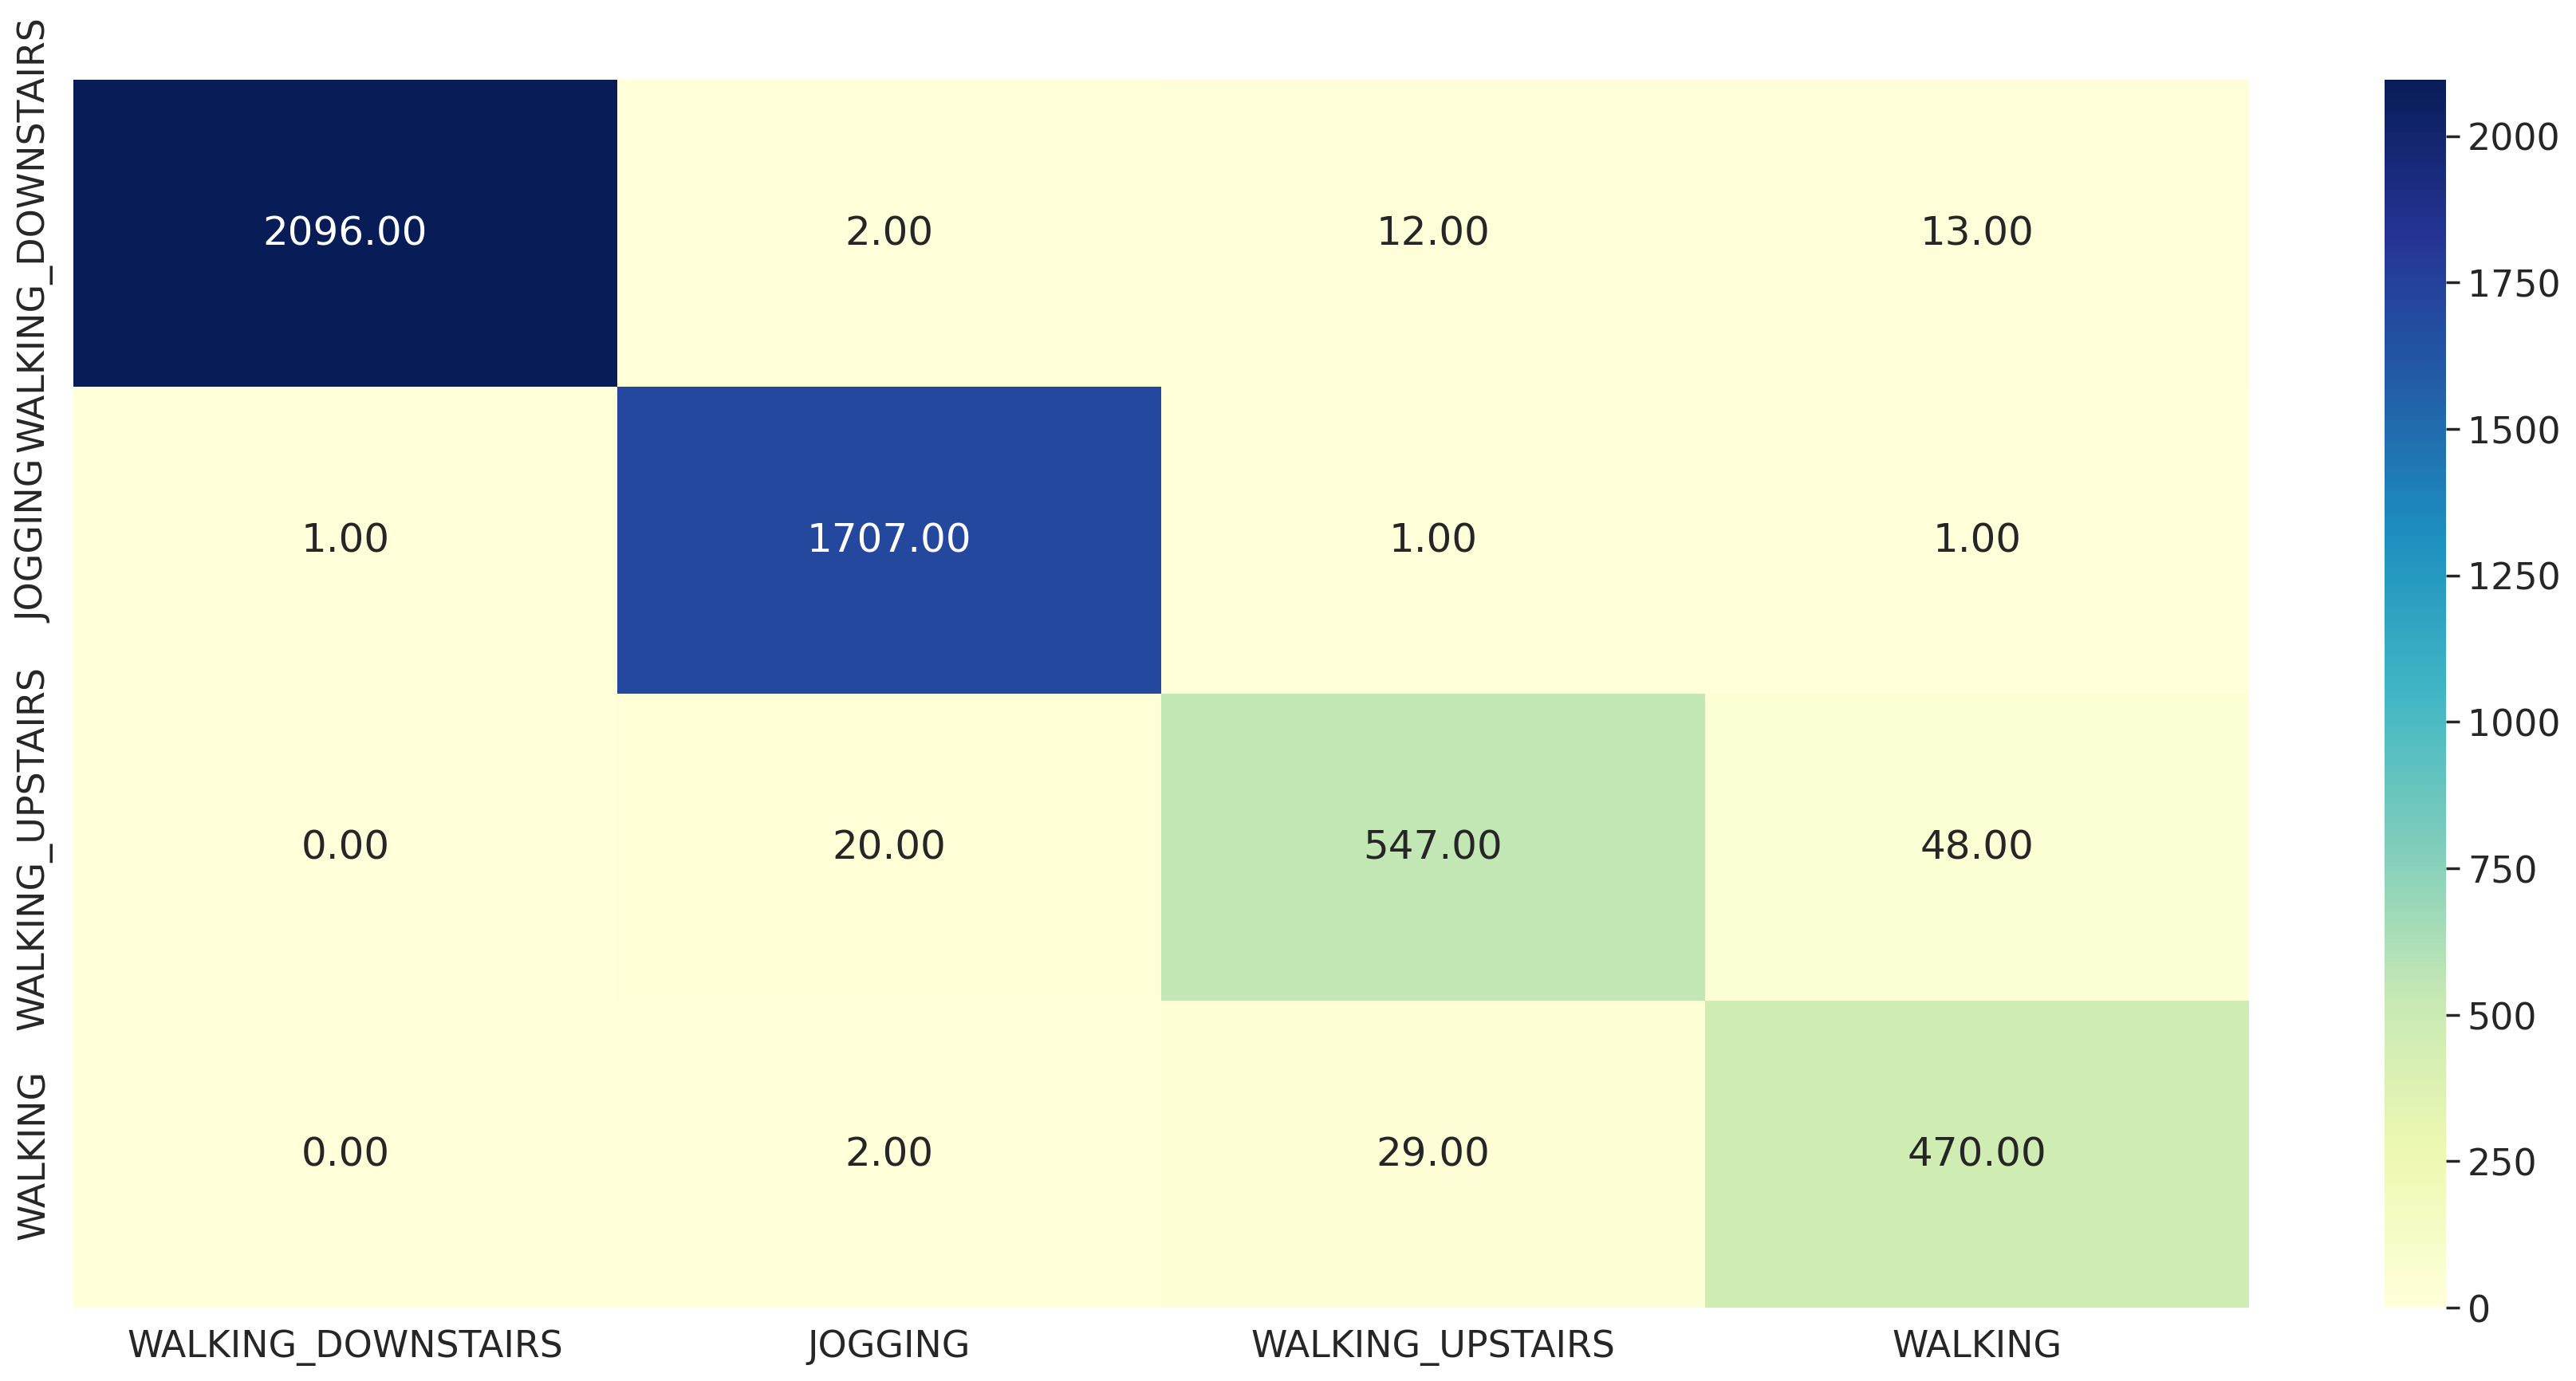

In [42]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_pred=model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y_test_hot, axis=-1)

LABELS = ['WALKING_DOWNSTAIRS','JOGGING','WALKING_UPSTAIRS','WALKING']
cm=confusion_matrix(y_true,y_pred)

#print(cm)
print('f1_score = ', f1_score(y_test, y_pred, average='weighted'))
print(accuracy_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')